In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 200)
pd.set_option('max_columns', 200)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

### 1. check relative faster %

In [4]:
startDate = '20201027'
endDate = '20201027'



readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
rawOrderLog = []
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_csv(thisPath)
    data = data.rename(columns={'mdClockAtArrival': 'caamd'})
    rawOrderLog += [data]
rawOrderLog = pd.concat(rawOrderLog, sort=False)

# rawOrderLog = pd.read_pickle(r'A:\temp\speedCheck\zt96_statwo_20200818.pkl')


for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
            'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
    rawOrderLog[col] = rawOrderLog[col].astype('int64')   
rawOrderLog = rawOrderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

rawOrderLog = rawOrderLog[rawOrderLog["secid"] >= 1000000]


targetStock = rawOrderLog['secid'].unique()
targetStock = np.array([int(str(i)[1:]) for i in targetStock])
targetStockSZ = sorted(targetStock[targetStock < 600000])
targetStockSH = sorted(targetStock[targetStock >= 600000])

rawOrderLog['clock'] = rawOrderLog['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
rawOrderLog['broker'] = rawOrderLog['accCode'] // 100
rawOrderLog["broker"] = np.where(rawOrderLog["accCode"].astype(str).apply(lambda x: len(x) == 6), rawOrderLog['accCode'] // 10000, rawOrderLog["broker"])
rawOrderLog['colo_broker'] = rawOrderLog['colo'].str[:2] + '_' + rawOrderLog['broker'].astype('str')
rawOrderLog['order'] = rawOrderLog.groupby(['date', 'accCode', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['group'] = rawOrderLog.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['startClock'] = rawOrderLog.groupby(['order'])['clockAtArrival'].transform('first')
rawOrderLog['duration'] = rawOrderLog['clockAtArrival'] - rawOrderLog['startClock']
rawOrderLog['orderPrice'] = rawOrderLog['orderPrice'].apply(lambda x: round(x, 2))
rawOrderLog['tradePrice'] = rawOrderLog['tradePrice'].apply(lambda x: round(x, 2))
rawOrderLog['orderDirection1'] = np.where(rawOrderLog["orderDirection"] == -2, -1, np.where(
    rawOrderLog["orderDirection"] == 2, 1, rawOrderLog["orderDirection"]))
orderLog = rawOrderLog.copy()

### make sure updateType == 7 orders < 20 per account, < 100 in total
if orderLog[orderLog['updateType'] == 7].shape[0] != 0:
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['vai'].count().max() < 20)
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['vai'].count().sum() < 100)

### make sure updateType == 6 orders < 5% per account
k1 = orderLog[orderLog['updateType'] == 6].groupby('accCode')['vai'].size().reset_index()
k2 = orderLog.groupby('accCode')['vai'].size().reset_index()
k = pd.merge(k1, k2, on='accCode', how='left')
k['prob'] = k['vai_x']/k['vai_y']
assert(sum(k['prob'] >= 0.05) == 0)

### make sure CYB stocks total absOrderSize < 30w
assert(orderLog[(orderLog['secid'] >= 2300000) & (orderLog['updateType'] == 0)]['absOrderSize'].max() <= 300000)


### make sure no order has shares > 80w or notional > 800w
orderLog['orderNtl'] = orderLog['absOrderSize'] * orderLog['orderPrice']
# assert(orderLog[orderLog['absOrderSize'] > 800000].shape[0] == 0)
# assert(orderLog[orderLog['orderNtl'] > 8000000].shape[0] == 0)
if orderLog[orderLog['absOrderSize'] > 800000].shape[0] > 0:
    print('some order quantity are > 80w')
    display(orderLog[orderLog['absOrderSize'] > 800000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                         'orderNtl', 'orderDirection', 'clock', 'order']])
            
if orderLog[orderLog['orderNtl'] > 8000000].shape[0] > 0:
    print('some order ntl are > 800w')
    display(orderLog[orderLog['orderNtl'] > 8000000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                      'orderNtl', 'orderDirection', 'clock', 'order', "updateType", 
                                                      "tradePrice", "absOrderSizeCumFilled", "absFilledThisUpdate"]])

### make sure same direction in same colo_broker
orderLog['directNum'] = orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].transform('nunique')
if len(orderLog[orderLog['directNum'] != 1]) > 0:
    print('opposite direction for same date, same secid, same vai')
    display(orderLog[orderLog['directNum'] != 1][['date', 'accCode', 'secid', 'vai', 'orderDirection']])
    orderLog = orderLog[orderLog['directNum'] == 1]

assert((orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].nunique() == 1).all() == True)

## make sure each account, secid, vai only has one insertion
a = orderLog[orderLog['updateType'] == 0].groupby(['date', 'accCode', 'secid', 'vai', 'order'])['clockAtArrival'].count()
if len(a[a > 1]) > 0:
    print('more than one insertion at same time')
    a = a[a>1].reset_index()
    display(a)
    orderLog = orderLog[~(orderLog['order'].isin(a['order'].unique()))]

orderLog['isMsg'] = np.where(orderLog['updateType'] == 0, 
                             np.where(orderLog['mse'] == 100, 1, 0), np.nan)
orderLog['isMsg'] = orderLog.groupby(['order'])['isMsg'].ffill()

placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]
print('%.2f%% SZE orders triggered by msg data'%(placeSZE[placeSZE['isMsg'] == 1].shape[0]/placeSZE.shape[0]*100))

### make sure there is no unexpected updateType 
def getTuple(x):
    return tuple(i for i in x)

checkLog = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4))]
checkLog = checkLog.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
checkLog['status'] = np.where(checkLog['updateType'].isin([(0, 2, 4), (0, 2, 2, 4), (0, 2, 2, 1, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4), (0, 2, 4, 1, 4), (0, 4), (0, 4, 1, 4), (0, 2, 2, 4, 1, 4), (0, 4, 2, 4)]),0,
                     np.where(checkLog['updateType'].isin([(0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3), (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 4, 1, 3), (0, 2, 2, 1, 4, 3), (0, 4, 2, 4, 1, 3), (0, 4, 2, 1, 3), (0, 2, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 2, 4, 1, 4, 3)]), 1,
                     np.where(checkLog['updateType'].isin([(0, 2, 1, 3), (0, 2, 2, 1, 3)]), 2,
                     np.where(checkLog['updateType'].isin([(0, 3)]), 3,
                     np.where(checkLog['updateType'].isin([(0,), (0, 2), (0, 2, 1), (0, 2, 2), (0, 2, 4, 1)]), 4, 5)))))
display(set(checkLog["updateType"].unique()) - set([(0, 2, 4), (0, 2, 2, 4), (0, 2, 2, 1, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4),
                                                    (0, 2, 4, 1, 4), (0, 4), (0, 4, 1, 4), (0, 2, 2, 4, 1, 4), (0, 4, 2, 4), 
                                                    (0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3),
                                                    (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 4, 1, 3), (0, 2, 2, 1, 4, 3),
                                                    (0, 4, 2, 4, 1, 3), (0, 4, 2, 1, 3), (0, 2, 1, 3), (0, 2, 2, 1, 3),
                                                    (0, 3), (0,), (0, 2), (0, 2, 1), (0, 2, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 2, 4, 1, 4, 3), 
                                                    (0, 2, 2), (0, 2, 4, 1)]))

display(checkLog[checkLog['status'] == 5])
orderLog = pd.merge(orderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
orderLog = orderLog[orderLog['status'].isin([0, 1, 2])].reset_index(drop=True)

### check status==0 got all traded
a = orderLog[orderLog['status'] == 0]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in total trade, any fill != total cases')
display(a[a['filled'] != a['total']])
if a[a['filled'] != a['total']].shape[0] > 0:
    removeOrderLs = a[a['filled'] != a['total']]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### check status==1 got partial traded
a = orderLog[orderLog['status'] == 1]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in partial trade, any fill >= total or fill is 0 cases for updateType 4')
display(a[(a['filled'] >= a['total']) | (a['filled'] == 0)])
if a[(a['filled'] >= a['total']) | (a['filled'] == 0)].shape[0] > 0:
    removeOrderLs = a[(a['filled'] >= a['total']) | (a['filled'] == 0)]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### check if any cancellation within 1 sec
a = orderLog[(orderLog['updateType'] == 1) & (orderLog['duration'] < 1e6)]
print('any cancellation within 1 sec')
display(a)
if a.shape[0] > 0:
    removeOrderLs = a['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]

orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
orderLog['orderNtl'] = orderLog['orderPrice'] * orderLog['absOrderSize']
orderLog['tradeNtl'] = np.where(orderLog['updateType'] == 4, orderLog['tradePrice']*orderLog['absFilledThisUpdate'], 0)
orderLog["ars"] = orderLog.groupby(['order'])['ars'].transform('first')
orderLog["server"] = orderLog["colo"].apply(lambda x: x.split("_")[0] + x.split("_")[1] + x.split("_")[2])
orderLog["server_account"] = orderLog["server"] + '_' + orderLog['accCode'].astype('str')
orderLog["colo_account"] = orderLog["colo"].str[:2] + '_' + orderLog['accCode'].astype('str')
orderLog["time"] = orderLog["clock"].apply(lambda x: x.strftime("%H%M%S")).astype(int)

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,19,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


opposite direction for same date, same secid, same vai


,date,accCode,secid,vai,orderDirection
56323,20200914,8854,1603008,8905434,-1
56324,20200914,8854,1603008,8905434,-1
56325,20200914,8854,1603008,8905434,-1
56326,20200914,528701,1603008,8905434,1
56327,20200914,528701,1603008,8905434,1
...,...,...,...,...,...
2886355,20200925,8854,2300766,1542201,1
2886356,20200925,8854,2300766,1542201,1
2886357,20200925,8854,2300766,1542201,1
2886358,20200925,8854,2300766,1542201,1


more than one insertion at same time


,date,accCode,secid,vai,order,clockAtArrival
0,20200914,5273,2300550,3100,7203,2
1,20200914,6683,2000688,1852523,27948,2
2,20200914,6683,2300723,1201900,29521,2
3,20200914,8854,2000688,2980019,30834,2
4,20200914,8854,2002961,556897,31125,2
...,...,...,...,...,...,...
479,20200925,975602,1603192,445733,711392,2
480,20200925,975602,1603297,462866,711541,2
481,20200925,975602,1603322,517500,711587,2
482,20200925,975602,1603722,1671500,711965,2


99.65% SZE orders triggered by msg data


{(0, 2, 6), (0, 6)}

,order,updateType,status
24112,24114,"(0, 2, 6)",5
24445,24447,"(0, 2, 6)",5
24679,24681,"(0, 2, 6)",5
24718,24720,"(0, 2, 6)",5
34044,34056,"(0, 6)",5
...,...,...,...
678856,679374,"(0, 6)",5
678886,679404,"(0, 6)",5
678908,679426,"(0, 6)",5
678980,679498,"(0, 6)",5


in total trade, any fill != total cases


,order,filled,total
7429,9735,300,400
8203,10691,6200,14600
9187,11799,90000,143700
10058,12769,2200,2300
15319,18984,3400,32200
...,...,...,...
508182,704463,86,4700
508423,704862,15200,17100
510405,707939,9800,12500
513026,711885,100,400


in partial trade, any fill >= total or fill is 0 cases for updateType 4


,order,filled,total


any cancellation within 1 sec


,Unnamed: 0,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,internalId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,l4tr,clock,broker,colo_broker,order,group,startClock,duration,orderDirection1,orderNtl,directNum,isMsg,status


In [20]:
checkLog = orderLog[orderLog['updateType'].isin([0, 3, 4])].reset_index(drop=True)
checkLog = checkLog[checkLog['duration'] <= 1e6]

ol = checkLog[(checkLog["updateType"] == 0) & (~checkLog["ars"].isin([121, 221, 321, 131, 231, 331]))]["order"].unique()
display(len(ol))
checkLog = checkLog[checkLog["order"].isin(ol)]

checkLog['accountNum'] = checkLog.groupby(['date', 'secid', 'vai'])['server_account'].transform('nunique')
checkLog = checkLog[checkLog['accountNum'] >= 2]
checkLog['cumFillSize'] = checkLog.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
checkLog['status'] = np.where(checkLog['cumFillSize'] == 0, 2, 
                                np.where(checkLog['cumFillSize'] < checkLog['absOrderSize'], 1, 0))
checkLog = checkLog.groupby(['group', 'order'])[['date', 'server_account', 'secid', 'vai', 'status']].first().reset_index()

for exchg in ['SZE']:
    
    print(exchg)
    
    if exchg == 'SSE':
        exchangeLog = checkLog[checkLog['secid'] < 2000000]
    else:
        exchangeLog = checkLog[checkLog['secid'] >= 2000000]
    
    result = {}
    for col in ['date', 'broker1', 'broker2', 'isFast']:
        result[col] = []

    for group, groupData in exchangeLog.groupby(['group']):
        date = groupData['date'].values[0]
        brokerLs = groupData['server_account'].values
        if len(brokerLs) == 0:
            continue
        statusLs = groupData['status'].values
        ixLs = [i for i in range(len(brokerLs))]
        for k, broker1, status1 in zip(ixLs[:-1], brokerLs[:-1], statusLs[:-1]):
            for broker2, status2 in zip(brokerLs[k+1:], statusLs[k+1:]):
                if broker1 != broker2:
                    result['date'] += [date, date]
                    result['broker1'] += [broker1, broker2]
                    result['broker2'] += [broker2, broker1]

                    if status1 < status2:
                        result['isFast'] += [1, 0]
                    elif status1 > status2:
                        result['isFast'] += [0, 1]
                    else:
                        result['isFast'] += [-1, -1]                

    result = pd.DataFrame(result)
    result = result[result['isFast'] != -1]
    result['count'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('count')
    result['fasterSum'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
    result['faster'] = result['fasterSum']/result['count']

    
    summary = pd.DataFrame()
    summaryCols = []
    countCols = []
    fasterCols = []
    for date in result['date'].unique():
        a = result[result['date'] == date].reset_index(drop=True)
        a['count'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('count')
        a['fasterSum'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
        a['faster'] = a['fasterSum']/a['count']
        a = a.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
        a.columns = ['broker1', 'broker2', '%s count'%date, '%s faster'%date]
        summaryCols += ['%s count'%date, '%s faster'%date]
        countCols += ['%s count'%date]
        fasterCols += ['%s faster'%date]
        
        if summary.empty:
            summary = a.copy()
        else:
            summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
    
    a = result.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
    a.columns = ['broker1', 'broker2', 'total count', 'total faster']
    summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
    summaryCols = ['total count', 'total faster'] + summaryCols
    
    countCols += ['total count']
    fasterCols += ['total faster']
    summary['b1'] = summary['broker1'].str[7:11].astype(int) // 100
    summary['b2'] = summary['broker2'].str[7:11].astype(int) // 100
#     summary = summary.groupby(['broker1', 'broker2'])[summaryCols].first()
    for col in countCols:
        summary[col] = summary[col].fillna(0)
        summary[col] = summary[col].astype('int64')
        
    for col in fasterCols:
        summary[col] = summary[col].fillna(-1)
        summary[col] = summary[col].apply(lambda x: '%.0f%%'%(x*100))
        summary[col] = np.where(summary[col] == '-100%', ' ', summary[col])
    
#     summary = summary.rename(columns={"broker1":"account1", "broker2":"account2"})
#     summary = summary.groupby(['account1', 'account2'])[summaryCols].first()
#     from IPython.display import display, HTML
#     display(HTML(summary.iloc[:, :2].to_html()))
#     summary["tt"]=summary[["broker1", "broker2"]].min(axis=1).astype(str) + ' - ' + summary[["broker1", "broker2"]].max(axis=1).astype(str)
#     summary = summary.sort_values(by=["tt", "broker1"])
#     s1 = summary.groupby("tt").first().reset_index(drop=True)
    display(summary[((summary["b1"] == 66)) & (summary['total count'] >= 30)])

68620

SZE


,broker1,broker2,20200817 count,20200817 faster,20200818 count,20200818 faster,20200819 count,20200819 faster,20200820 count,20200820 faster,total count,total faster,b1,b2
38,zs6601_6678,zs9403_9448,23,9%,11,36%,21,33%,33,24%,88,24%,66,94
41,zs6601_6683,zs5401_5456,23,13%,12,0%,15,0%,7,0%,57,5%,66,54
42,zs6601_6683,zs9201_9208,19,0%,2,0%,7,0%,4,0%,32,0%,66,92
43,zs6601_6683,zs9202_9243,26,8%,19,5%,26,4%,20,0%,91,4%,66,92
44,zs6601_6683,zs9603_9685,168,0%,80,4%,0,,0,,248,1%,66,96
45,zs6601_6683,zs9606_9758,37,5%,9,0%,14,0%,3,0%,63,3%,66,97
46,zs6601_6683,zt8802_8854,16,100%,7,100%,17,100%,9,67%,49,94%,66,88


### 2. check the time duration between triggering and insertion 

In [2]:
startTm = datetime.datetime.now()


startDate = '20201105'
endDate = '20200807'

# readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
# dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
# dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
# dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
# dateLs = dateLs[(dateLs >= startDate) & (dateLs <= endDate)]

dateLs = ['20200730', '20200731', '20200803', '20200804', '20200805', '20200806', '20200807']

for date in dateLs:
        
#     readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
#     orderLog = pd.read_csv(os.path.join(readPath, 'speedCompare_%s.csv'%date))
    orderLog = pd.read_pickle(r'A:\temp\zs66 speed\speedCompare_zs66_0730_0807.pkl')
    orderLog = orderLog[orderLog['date'] == int(date)]
    orderLog = orderLog.fillna(0)
    
    for col in ['clockAtArrival', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
                'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
        orderLog[col] = orderLog[col].astype('int64')

    orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)
    orderLog = orderLog[orderLog["secid"] >= 1000000]

    targetStock = orderLog['secid'].unique()
    targetStock = np.array([int(str(i)[1:]) for i in targetStock])
    targetStockSZ = sorted(targetStock[targetStock < 600000])
    targetStockSH = sorted(targetStock[targetStock >= 600000])
        
    readPath = r'\\192.168.10.30\Kevin_zhenyu\rawData'
    mdOrderLogPath = glob.glob(os.path.join(readPath, 'logs_%s_zs_92_01***'%date, 'mdOrderLog***.csv'))[-1]
    mdTradeLogPath = glob.glob(os.path.join(readPath, 'logs_%s_zs_92_01***'%date, 'mdTradeLog***.csv'))[-1]
    
    mdOrderLog = pd.read_csv(mdOrderLogPath)
    mdOrderLog = mdOrderLog[mdOrderLog['SecurityID'].isin(targetStockSZ)]
    mdOrderLog['OrderType'] = mdOrderLog['OrderType'].astype(str)
    mdOrderLog = mdOrderLog[['clockAtArrival', 'sequenceNo', 'TransactTime', 'SecurityID', 'ApplSeqNum', 'Side',
                             'OrderType', 'Price', 'OrderQty']]
    
    mdTradeLog = pd.read_csv(mdTradeLogPath)
    mdTradeLog['ExecType'] = mdTradeLog['ExecType'].astype(str)
    mdTradeLog = mdTradeLog[mdTradeLog['SecurityID'].isin(targetStockSZ)]
    mdTradeLog['volumeThisUpdate'] = np.where(mdTradeLog['ExecType'] == 'F', mdTradeLog['TradeQty'], 0)
    mdTradeLog['cum_volume'] = mdTradeLog.groupby(['SecurityID'])['volumeThisUpdate'].cumsum()
    mdTradeLog = mdTradeLog[['clockAtArrival', 'sequenceNo', 'TransactTime', 'SecurityID', 'ApplSeqNum', 'cum_volume',
                             'ExecType', 'TradePrice', 'TradeQty', 'TradeMoney', 'BidApplSeqNum', 'OfferApplSeqNum']]

    mdMsgData = pd.concat([mdOrderLog, mdTradeLog], sort=False)
    del mdOrderLog
    del mdTradeLog
    
    mdMsgData = mdMsgData.sort_values(by=['sequenceNo']).reset_index(drop=True)
    
    mdMsgData["agg_trade"] = np.where((mdMsgData["ApplSeqNum"] == mdMsgData["BidApplSeqNum"] + 1) & (mdMsgData["ExecType"] == "F"), 1, np.where(
    (mdMsgData["ApplSeqNum"] == mdMsgData["OfferApplSeqNum"] + 1) & (mdMsgData["ExecType"] == "F"), 1, 0))
    mdMsgData["agg"] = mdMsgData.groupby(["SecurityID"])["agg_trade"].shift(-1)
    mdMsgData["orderNum"] = np.where(mdMsgData["ExecType"].isnull(), 1, 0)
    mdMsgData["cumorderNum"] = mdMsgData.groupby("SecurityID")["orderNum"].cumsum()
    mdMsgData["cumorderNum2"] = np.nan
    mdMsgData.loc[mdMsgData["agg"]==1, "cumorderNum2"] = mdMsgData.loc[mdMsgData["agg"]==1, "cumorderNum"]
    mdMsgData["cumorderNum2"] = mdMsgData.groupby("SecurityID")["cumorderNum2"].ffill()
    mdMsgData.loc[mdMsgData["cumorderNum2"] == mdMsgData["cumorderNum"], "cum_volume"] = mdMsgData[mdMsgData["cumorderNum2"] == mdMsgData["cumorderNum"]]\
    .groupby(["SecurityID", "cumorderNum"])["cum_volume"].transform("max")
    
    mdMsgData = mdMsgData.sort_values(by=['sequenceNo']).reset_index(drop=True)

    mdMsgData['cum_volume'] = mdMsgData.groupby(['SecurityID'])['cum_volume'].ffill()
    mdMsgData['cum_volume'] = mdMsgData.groupby(['SecurityID'])['cum_volume'].backfill()
    mdMsgData['ExecType'] = mdMsgData['ExecType'].fillna('2')
    mdMsgData['TradeQty'] = mdMsgData['TradeQty'].fillna(0)
    
    saveCols = ['clockAtArrival', 'sequenceNo', 'TransactTime', 'SecurityID', 'cum_volume', 'ApplSeqNum', 
                'Side', 'OrderType', 'Price', 'OrderQty', 'ExecType', 'TradePrice', 'TradeQty', 'TradeMoney',
                'BidApplSeqNum', 'OfferApplSeqNum', "agg"]
    mdMsgData = mdMsgData[saveCols]
    savePath = r'L:\orderLog\mdData'
    mdMsgData.to_pickle(os.path.join(savePath, 'mdLog66_msg_%s.pkl'%date))
    
print(datetime.datetime.now() - startTm)

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Ana

1:05:25.354989


In [3]:
startTm = datetime.datetime.now()

startDate = '20201106'
endDate = '20201106'

readPath = r'\\192.168.10.34\random_backup\Kevin_zhenyu\orderLog\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
dateLs = dateLs[(dateLs >= startDate) & (dateLs <= endDate)]
# dateLs = ['20200730', '20200731', '20200803', '20200804', '20200805', '20200806', '20200807']

for thisDate in dateLs:
    
#     orderLog = pd.read_pickle(r'A:\temp\zs66 speed\speedCompare_zs66_0730_0807.pkl')
#     orderLog = orderLog[orderLog['date'] == int(thisDate)]
#     orderLog = orderLog.fillna(0)
    
    readPath = r'\\192.168.10.34\random_backup\Kevin_zhenyu\orderLog\equityTradeLogs'
    rawOrderLog = pd.read_csv(os.path.join(readPath, 'speedCompare_%s.csv'%thisDate))
    for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
                'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
        rawOrderLog[col] = rawOrderLog[col].fillna(0)
        rawOrderLog[col] = rawOrderLog[col].astype('int64')   
    rawOrderLog = rawOrderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

    rawOrderLog = rawOrderLog[rawOrderLog["secid"] >= 1000000]

    rawOrderLog['clock'] = rawOrderLog['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
    rawOrderLog["broker"] = np.where(rawOrderLog["accCode"].astype(str).apply(lambda x: len(x) == 6), rawOrderLog['accCode'] // 10000, rawOrderLog['accCode'] // 100)
    rawOrderLog['colo_broker'] = rawOrderLog['colo'].str[:2] + '_' + rawOrderLog['broker'].astype('str')
    rawOrderLog['colo_account'] = rawOrderLog['colo'].str[:2] + '_' + rawOrderLog['accCode'].astype('str')
    rawOrderLog['order'] = rawOrderLog.groupby(['date', 'accCode', 'secid', 'vai']).grouper.group_info[0]
    rawOrderLog['group'] = rawOrderLog.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
    rawOrderLog['startClock'] = rawOrderLog.groupby(['order'])['clockAtArrival'].transform('first')
    rawOrderLog['duration'] = rawOrderLog['clockAtArrival'] - rawOrderLog['startClock']
    rawOrderLog['orderPrice'] = rawOrderLog['orderPrice'].apply(lambda x: round(x, 2))
    rawOrderLog['tradePrice'] = rawOrderLog['tradePrice'].apply(lambda x: round(x, 2))
    rawOrderLog['orderDirection1'] = np.where(rawOrderLog["orderDirection"] == -2, -1, np.where(
        rawOrderLog["orderDirection"] == 2, 1, rawOrderLog["orderDirection"]))
    orderLog = rawOrderLog.copy()
    
    
    ### Assertion 1:  make sure same direction in same date, secid, vai
    print('=======================================================================================')
    print('1. same date, secid, vai: same direction')
    orderLog['directNum'] = orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].transform('nunique')
    if len(orderLog[orderLog['directNum'] != 1]) > 0:
        print('opposite direction for same date, same secid, same vai')
        display(orderLog[(orderLog['directNum'] != 1) & (orderLog['updateType'] == 0)][['date', 'accCode', 'secid', 'vai', 'orderDirection', 'order']])
        orderLog = orderLog[orderLog['directNum'] == 1]

    assert((orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].nunique() == 1).all() == True)

    ## Assertion 2:  make sure each account, secid, vai only has one insertion
    print('=======================================================================================')
    print('2. same date, secid, vai, accCode: one insertion')
    a = orderLog[orderLog['updateType'] == 0].groupby(['date', 'accCode', 'secid', 'vai', 'order'])['clockAtArrival'].count()
    if len(a[a > 1]) > 0:
        print('more than one insertion at same time')
        a = a[a>1].reset_index()
        display(a)
        orderLog = orderLog[~(orderLog['order'].isin(a['order'].unique()))]

    orderLog['isMsg'] = np.where(orderLog['updateType'] == 0, 
                                 np.where(orderLog['mse'] == 100, 1, 0), np.nan)
    orderLog['isMsg'] = orderLog.groupby(['order'])['isMsg'].ffill()

    placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]
    print('%.2f%% SZE orders triggered by msg data'%(placeSZE[placeSZE['isMsg'] == 1].shape[0]/placeSZE.shape[0]*100))


    ### Assertion 3:  check IPO stocks selling status
    print('=======================================================================================')
    print('3. IPO stocks selling (ars = 301, 302)')
    if orderLog[orderLog['ars'].isin([301, 302])].shape[0] != 0:
        kk = orderLog[orderLog['ars'].isin([301, 302])]
        print(kk)
        try:
            assert(kk[kk['orderDirection1'] == 1].shape[0] == 0)
            print('we only sell, never buy')
        except:
            print('There are IPO buy side orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
            print(kk[kk['orderDirection1'] == 1])
        kk1 = kk[kk['updateType'] == 0]
        kk1 = kk1.sort_values(by=['accCode', 'secid','clockAtArrival'])
        kk1['diff'] = kk1.groupby(['accCode', 'secid'])['clockAtArrival'].apply(lambda x: x-x.shift(1))
        kk1['diff'] = kk1['diff'].fillna(0)
        try:
            assert(kk1[kk1['diff'] < 10e6].shape[0] == 0)
            print('for each stock in the same account, there is no insertion within 10 seconds of the previous insertion')
        except:
            print('There are insertion within 10 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
            print(kk1[kk1['diff'] < 10e6])
        kk2 = kk[(kk['updateType'] == 1)]
        try:
            assert(kk2[kk2['duration'] < 3e6].shape[0] == 0)
            print('for each stock in the same account, the cancellation of an order happens more than 3 seconds after the insertion')
        except:
            print('There are cancellation within 3 seconds for orders under same account same stock!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
            print(kk2[kk2['duration'] < 3e6])


    ### Assertion 4: check updateType == 7 orders, make sure updateType == 7 orders < 20 per account, < 100 in total
    print('=======================================================================================')
    print('4. updateType 7 orders')
    if orderLog[orderLog['updateType'] == 7].shape[0] != 0:
        assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['order'].nunique().max() < 20)
        assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['order'].nunique().sum() < 100)

    ### Assertion 5: check updateType == 6 orders, make sure updateType == 6 orders < 5% per account
    print('=======================================================================================')
    print('5. updateType 6 orders')
    k1 = orderLog[orderLog['updateType'] == 6].groupby('accCode')['order'].nunique().reset_index()
    k2 = orderLog.groupby('accCode')['order'].nunique().reset_index()
    k = pd.merge(k1, k2, on='accCode', how='left')
    k['prob'] = k['order_x']/k['order_y']
    try:
        assert(sum(k['prob'] >= 0.05) == 0)
    except:
        print('There are accounts with more than 5% updateType 6 orders!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        print(k[k['prob'] >= 0.05])

    ### Assertion 6: check CYB orders, make sure CYB stocks total absOrderSize < 30w
    print('=======================================================================================')
    print('6. CYB stocks total order size < 30w')
    try:
        assert(orderLog[(orderLog['secid'] >= 2300000) & (orderLog['updateType'] == 0)]['absOrderSize'].max() <= 300000)
    except:
        print('CYB stocks total absOrderSize >= 30w!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')


    ### Assertion 7:  make sure there is no unexpected updateType 
    print('=======================================================================================')
    print('7. unexpected updateType')
    def getTuple(x):
        return tuple(i for i in x)

    checkLog = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4))]
    checkLog = checkLog.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
    checkLog['status'] = np.where(checkLog['updateType'].isin([(0, 2, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4), (0, 2, 4, 1, 4), (0, 4), (0, 1, 4), (0, 4, 1, 4), (0, 2, 2, 4), (0, 4, 2, 4), (0, 2, 2, 1, 4), (0, 2, 2, 4, 1, 4)]),0,
                         np.where(checkLog['updateType'].isin([(0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3), (0, 1, 4, 3),
                                                                   (0, 2, 2, 4, 1, 3), (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 1, 4, 3), (0, 4, 2, 4, 1, 3),
                                                                   (0, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 1)]), 1,
                         np.where(checkLog['updateType'].isin([(0, 2, 1, 3), (0, 2, 2, 1, 3), (0, 2, 3), (0, 3), (0, 1, 3), (0, ), (0, 2), (0, 2, 1), (0, 2, 2)]), 2, 3)))

    orderLog = pd.merge(orderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
    orderLog = orderLog[orderLog['status'].isin([0, 1, 2])].reset_index(drop=True)

    ### Assertion 8:  make sure status==0 got all traded
    print('=======================================================================================')
    print('8. status == 0: all traded')
    a = orderLog[orderLog['status'] == 0]
    a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
    a.columns = ['order', 'filled', 'total']
    print('in total trade, any fill != total cases')
    display(a[a['filled'] != a['total']])
    if a[a['filled'] != a['total']].shape[0] > 0:
        removeOrderLs = a[a['filled'] != a['total']]['order'].unique()
        orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]

    ### Assertion 9:  make sure status==1 got partial traded
    print('=======================================================================================')
    print('9. status == 1: partial traded')
    a = orderLog[orderLog['status'] == 1]
    a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
    a.columns = ['order', 'filled', 'total']
    print('in partial trade, any fill >= total or fill is 0 cases for updateType 4')
    display(a[(a['filled'] >= a['total']) | (a['filled'] == 0)])
    if a[(a['filled'] >= a['total']) | (a['filled'] == 0)].shape[0] > 0:
        removeOrderLs = a[(a['filled'] >= a['total']) | (a['filled'] == 0)]['order'].unique()
        orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]

    ### Assertion 10: make sure no cancellation within 1 sec
    print('=======================================================================================')
    print('10. no cancellation within 1 sec')
    a = orderLog[(orderLog['updateType'] == 1) & (orderLog['duration'] < 1e6)]
    print('any cancellation within 1 sec')
    display(a)
    if a.shape[0] > 0:
        removeOrderLs = a['order'].unique()
        orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]


    ### Assertion 11: make sure no order has shares > 80w or notional > 800w
    print('=======================================================================================')
    print('11. Orders with size > 80w or notional > 800w')
    orderLog['orderNtl'] = orderLog['absOrderSize'] * orderLog['orderPrice']
    if orderLog[orderLog['absOrderSize'] > 800000].shape[0] > 0:
        print('some order quantity are > 80w')
        print(orderLog[orderLog['absOrderSize'] > 800000].groupby(['colo', 'accCode'])['order'].nunique())
        display(orderLog[orderLog['absOrderSize'] > 800000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                             'orderNtl', 'orderDirection', 'clock', 'order']])

    if orderLog[orderLog['orderNtl'] > 8000000].shape[0] > 0:
        print('some order ntl are > 800w')
        print(orderLog[orderLog['orderNtl'] > 8000000].groupby(['colo', 'accCode'])['order'].nunique())
        display(orderLog[orderLog['orderNtl'] > 8000000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                          'orderNtl', 'orderDirection', 'clock', 'order', "updateType", 
                                                          "tradePrice", "absOrderSizeCumFilled", "absFilledThisUpdate"]])

    removeOrderLs = list(set(orderLog[orderLog['absOrderSize'] > 800000]['order'].unique()) | set(orderLog[orderLog['orderNtl'] > 8000000]['order'].unique()))
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]


    orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

    orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
    orderLog['orderNtl'] = orderLog['orderPrice'] * orderLog['absOrderSize']
    orderLog['tradeNtl'] = np.where(orderLog['updateType'] == 4, orderLog['tradePrice']*orderLog['absFilledThisUpdate'], 0)
    orderLog = orderLog[orderLog['secid'] >= 2000000].reset_index(drop=True)
    
    # 1. market orders
    readPath = r'L:\orderLog\mdData'
    rawMsgDataSZ = pd.read_pickle(os.path.join(readPath, 'mdLog_msg_%s.pkl'%thisDate))
    orderDataSZ = rawMsgDataSZ[rawMsgDataSZ['ExecType'] == '2'][['SecurityID', 'ApplSeqNum', 'clockAtArrival', 'sequenceNo', 'Side', 'OrderQty', 'Price', 'cum_volume', "agg", "TransactTime"]].reset_index(drop=True)
    orderDataSZ['updateType'] = 0
    tradeDataSZ = pd.concat([rawMsgDataSZ[rawMsgDataSZ['ExecType'] == 'F'][['SecurityID', 'BidApplSeqNum', 'clockAtArrival', 'sequenceNo', 'TradePrice', 'TradeQty', 'cum_volume', "TransactTime"]],
                             rawMsgDataSZ[rawMsgDataSZ['ExecType'] == 'F'][['SecurityID', 'OfferApplSeqNum', 'clockAtArrival', 'sequenceNo', 'TradePrice', 'TradeQty', 'cum_volume', "TransactTime"]]], sort=False)
    tradeDataSZ['ApplSeqNum'] = np.where(tradeDataSZ['BidApplSeqNum'].isnull(), tradeDataSZ['OfferApplSeqNum'], tradeDataSZ['BidApplSeqNum'])
    tradeDataSZ['Side'] = np.where(tradeDataSZ['BidApplSeqNum'].isnull(), 2, 1)
    tradeDataSZ = tradeDataSZ[['SecurityID', 'ApplSeqNum', 'clockAtArrival', 'sequenceNo', 'Side', 'TradePrice', 'TradeQty', 'cum_volume', "TransactTime"]]
    tradeDataSZ['updateType'] = 4
    cancelDataSZ = rawMsgDataSZ[rawMsgDataSZ['ExecType'] == '4'][['SecurityID', 'BidApplSeqNum', 'OfferApplSeqNum', 'clockAtArrival', 'sequenceNo', 'TradePrice', 'TradeQty', 'cum_volume', "TransactTime"]].reset_index(drop=True)
    cancelDataSZ['ApplSeqNum'] = np.where(cancelDataSZ['BidApplSeqNum'] == 0, cancelDataSZ['OfferApplSeqNum'], cancelDataSZ['BidApplSeqNum'])
    cancelDataSZ['Side'] = np.where(cancelDataSZ['BidApplSeqNum'] == 0, 2, 1)
    cancelDataSZ = cancelDataSZ[['SecurityID', 'ApplSeqNum', 'clockAtArrival', 'sequenceNo', 'Side', 'TradeQty', 'cum_volume', "TransactTime"]]
    cancelDataSZ['updateType'] = 3

    msgDataSZ = pd.concat([orderDataSZ, tradeDataSZ, cancelDataSZ], sort=False)
    del orderDataSZ
    del tradeDataSZ
    del cancelDataSZ
    msgDataSZ = msgDataSZ.sort_values(by=['SecurityID', 'ApplSeqNum', 'sequenceNo']).reset_index(drop=True)
    msgDataSZ['TradePrice'] = np.where(msgDataSZ['updateType'] == 4, msgDataSZ['TradePrice'], 0)
    msgDataSZ['TradePrice'] = msgDataSZ['TradePrice'].astype('int64')
    msgDataSZ['TradeQty'] = np.where(msgDataSZ['updateType'] == 4, msgDataSZ['TradeQty'], 0)
    msgDataSZ['TradeQty'] = msgDataSZ['TradeQty'].astype('int64')
    msgDataSZ['secid'] = msgDataSZ['SecurityID'] + 2000000
    assert(msgDataSZ['ApplSeqNum'].max() < 1e8)
    msgDataSZ['StockSeqNum'] = msgDataSZ['SecurityID']*1e8 + msgDataSZ['ApplSeqNum']
    msgDataSZ['date'] = int(thisDate) 
    print('finish market orders')
 

    # 2. orderLog
    infoData = orderLog[(orderLog['date'] == int(thisDate)) & (orderLog["isMsg"] == 1) 
                        & (orderLog['updateType'].isin([0, 3, 4]))].reset_index(drop=True)
    del orderLog
    infoData['Price'] = infoData['orderPrice'].apply(lambda x: round(x*100, 0))
    infoData['Price'] = infoData['Price'].astype('int64')*100
    infoData['OrderQty'] = infoData['absOrderSize']
    infoData['Side'] = np.where(infoData['orderDirection1'] == 1, 1, 2)
    infoData['TradePrice'] = np.where(infoData['updateType'] == 4, round(infoData['tradePrice']*100, 0), 0)
    infoData['TradePrice'] = infoData['TradePrice'].astype('int64')*100
    statusInfo = infoData.groupby(['order'])['updateType'].apply(lambda x: tuple(x)).reset_index()
    statusInfo.columns = ['order', 'statusLs']
    tradePriceInfo = infoData.groupby(['order'])['TradePrice'].apply(lambda x: tuple(x)).reset_index()
    tradePriceInfo.columns = ['order', 'TradePriceLs']
    tradeQtyInfo = infoData.groupby(['order'])['absFilledThisUpdate'].apply(lambda x: tuple(x)).reset_index()
    tradeQtyInfo.columns = ['order', 'TradeQtyLs']
    infoData = infoData[infoData['updateType'] == 0]
    infoData = pd.merge(infoData, statusInfo, how='left', on=['order'], validate='one_to_one')
    infoData = pd.merge(infoData, tradePriceInfo, how='left', on=['order'], validate='one_to_one')
    infoData = pd.merge(infoData, tradeQtyInfo, how='left', on=['order'], validate='one_to_one')
    infoData['brokerNum'] = infoData.groupby(['date', 'secid', 'vai', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'])['colo_account'].transform('count')
    display(infoData[infoData['brokerNum'] >= 2].groupby(['colo', 'accCode'])['date'].count())
    display('%.2f%%'%(infoData[infoData['brokerNum'] >= 2].shape[0] / infoData.shape[0]*100))
    display(infoData[infoData['brokerNum'] >= 2].shape[0])
    display(infoData.shape[0])
    infoData = infoData[infoData['brokerNum'] == 1]
    infoData = infoData[['date', 'secid', 'vai', 'ars', "mrstaat", "mrstauc", 'exchange', 'group', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum', 'order', 'colo', 'accCode']]   
    
    print('finish our orders')
    
    # 3. find the position of our orders
    checkLog = msgDataSZ[msgDataSZ['updateType'] == 0]
    checkLog = pd.merge(checkLog, infoData.drop_duplicates(subset=['secid', 'ApplSeqNum'])[['secid', 'ApplSeqNum', 'ars']], 
                    on=['secid', 'ApplSeqNum'], how='left')
    checkLog['ApplSeqNum'] = np.where(~checkLog['ars'].isnull(), checkLog['ApplSeqNum'], checkLog['ars'])
    checkLog['start_time'] = np.where(~checkLog['ars'].isnull(), checkLog['clockAtArrival'], checkLog['ars'])
    checkLog.drop(["ars"],axis=1,inplace=True)
    checkLog['ApplSeqNum'] = checkLog.groupby(['secid'])['ApplSeqNum'].ffill()
    checkLog['start_time'] = checkLog.groupby(['secid'])['start_time'].ffill()
    checkLog['end_time'] = checkLog['start_time'] + 100*1e3
    checkLog = checkLog[(~checkLog['ApplSeqNum'].isnull()) & (checkLog['clockAtArrival'] > checkLog['start_time']) & 
                       (checkLog['clockAtArrival'] < checkLog['end_time'])]
    msgDataSZ = msgDataSZ[msgDataSZ['StockSeqNum'].isin(checkLog['StockSeqNum'].values)]
    print('finish get the interval')
    
    statusInfo = msgDataSZ.groupby(['StockSeqNum'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
    statusInfo.columns = ['StockSeqNum', 'statusLs']
    tradePriceInfo = msgDataSZ.groupby(['StockSeqNum'])['TradePrice'].apply(lambda x: tuple(x)).reset_index()
    tradePriceInfo.columns = ['StockSeqNum', 'TradePriceLs']
    tradeQtyInfo = msgDataSZ.groupby(['StockSeqNum'])['TradeQty'].apply(lambda x: tuple(x)).reset_index()
    tradeQtyInfo.columns = ['StockSeqNum', 'TradeQtyLs']
    del msgDataSZ
    checkLog = pd.merge(checkLog, statusInfo, how='left', on=['StockSeqNum'], validate='one_to_one')
    checkLog = pd.merge(checkLog, tradePriceInfo, how='left', on=['StockSeqNum'], validate='one_to_one')
    checkLog = pd.merge(checkLog, tradeQtyInfo, how='left', on=['StockSeqNum'], validate='one_to_one')  
    del statusInfo
    del tradePriceInfo
    del tradeQtyInfo

      
    try:
        checkLog = pd.merge(checkLog, infoData, how='left', on=['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], validate='many_to_one')
    except:
        print('There are orders with same pattern but different vai, same ApplSeqNum')
        display([infoData[infoData.duplicated(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)]])
        checkLog = pd.merge(checkLog, infoData, how='left', on=['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'])
    del infoData
    savePath = r'L:\orderLog\result\marketPos'
    checkLog.reset_index(drop=True).to_pickle(os.path.join(savePath, 'SZspeed_%s.pkl'%thisDate))
    del checkLog

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


1. same date, secid, vai: same direction
opposite direction for same date, same secid, same vai


,date,accCode,secid,vai,orderDirection,order
18727,20201106,6237,1600132,834900,1,81279
18731,20201106,6282,1600132,834900,-1,83232
19421,20201106,6237,1600132,1327945,1,81295
19425,20201106,6282,1600132,1327945,-1,83248
39823,20201106,6237,1600258,9556227,-1,81331
39826,20201106,9441,1600258,9556227,1,133813
39920,20201106,6237,1600258,9609927,1,81333
39925,20201106,6282,1600258,9609927,-1,83280
39988,20201106,6237,1600258,9832727,-1,81335
39992,20201106,6282,1600258,9832727,1,83281


2. same date, secid, vai, accCode: one insertion
more than one insertion at same time


,date,accCode,secid,vai,order,clockAtArrival
0,20201106,5456,2002833,1194980,77058,2
1,20201106,5456,2300709,20200,77565,2
2,20201106,6237,1603786,451953,81988,2
3,20201106,6237,1603786,456853,81989,4
4,20201106,6237,1603786,459253,81990,3
5,20201106,6237,1603868,915022,82170,2
6,20201106,6237,1603868,964281,82173,2
7,20201106,6237,1603868,1128581,82176,2
8,20201106,6237,2002212,4168538,82419,2
9,20201106,6237,2002294,5290420,82455,2


99.78% SZE orders triggered by msg data
3. IPO stocks selling (ars = 301, 302)
4. updateType 7 orders
5. updateType 6 orders
6. CYB stocks total order size < 30w
7. unexpected updateType
8. status == 0: all traded
in total trade, any fill != total cases


,order,filled,total
2560,4096,2500,8100
17325,23610,6998,7600
30950,42021,700,2500
32827,44482,9900,27500
47033,61687,7400,9400
61274,82996,700,1200
78314,105175,56,10000
80391,107382,200,300
90197,121130,9000,10100
91985,123685,1400,1500


9. status == 1: partial traded
in partial trade, any fill >= total or fill is 0 cases for updateType 4


,order,filled,total


10. no cancellation within 1 sec
any cancellation within 1 sec


,Unnamed: 0,date,clockAtArrival,caamd,colo,accCode,secid,vai,sdd,orderDirection,absOrderSize,updateType,tradePrice,absFilledThisUpdate,absOrderSizeCumFilled,tradeId,orderSysId,aaa,internalId,ars,mse,underlyingIndex,mrstaum,hee,mt,mrstauc,mrsb300,session,sequenceNo,l4tr,mrb100,clock,mrrlma,cancellationPending,cfe,orderPrice,finalState,mrm,orderId,mrss90,ms,threadId,mfe,mrstaat,ApplSeqNum,mrss300,mrsb90,mra100,mta,broker,colo_broker,colo_account,order,group,startClock,duration,orderDirection1,directNum,isMsg,status


11. Orders with size > 80w or notional > 800w
finish market orders


colo      accCode
zs_52_06  5222       3106
          5269        788
          5273       2737
          5275       1036
          5287        953
          5328         70
zs_52_08  5229        556
          5276        713
          5281         97
          5284        274
          5377        875
          5386       1368
zs_52_09  5225       1485
          5226       2152
          5230       1604
          5289        443
          5290       1849
          5291        177
zs_54_01  5456         46
          5470        254
          5474        439
zs_64_01  6480        566
zs_66_01  6623       1435
          6627       1532
          6631        431
          6634        638
          6678         38
          6683        579
zs_88_04  8865        601
          8924        999
          8967        407
          896702      847
zs_92_01  9208         20
zs_92_02  9243         47
zs_94_03  9448         49
          9461         44
zs_94_05  9451        179
          9454      

'24.81%'

39126

157691

finish our orders
finish get the interval
There are orders with same pattern but different vai, same ApplSeqNum


[           date    secid        vai  ars  mrstaat  mrstauc exchange  group  \
 37242  20201106  2002294   13191314  1.0   3000.0   1000.0      SZE  63538   
 37243  20201106  2002294  114867862  1.0  13000.0  11000.0      SZE  63539   
 
         Price  OrderQty  Side statusLs TradePriceLs TradeQtyLs  ApplSeqNum  \
 37242  293400       100     2   (0, 4)  (0, 293400)   (0, 100)  20726720.0   
 37243  293400       100     2   (0, 4)  (0, 293400)   (0, 100)  20726720.0   
 
         order      colo  accCode  
 37242   52551  zs_52_08     5276  
 37243  113376  zs_88_04     8856  ]

In [80]:
rawMsgDataSZ[(rawMsgDataSZ['sequenceNo'] >= 152458642) & (rawMsgDataSZ['sequenceNo'] <= 152458733) & (rawMsgDataSZ['SecurityID'] == 300454)][['SecurityID', 'sequenceNo', 'clockAtArrival', 'diff1', 'TransactTime', 'ApplSeqNum', 'Side', 'OrderQty', 'Price', 'TradePrice', 'TradeQty']].head(100)

,SecurityID,sequenceNo,clockAtArrival,diff1,TransactTime,ApplSeqNum,Side,OrderQty,Price,TradePrice,TradeQty
80913003,300454,152458642,1596178203677278,1.0,145001250,24840843,1.0,100.0,2149600.0,NaN,0.0
80913004,300454,152458643,1596178203677279,1.0,145001250,24840844,NaN,NaN,NaN,2149600.0,100.0
80913045,300454,152458717,1596178203677417,1.0,145001260,24840850,2.0,500.0,2146600.0,NaN,0.0
80913046,300454,152458718,1596178203677418,1.0,145001260,24840851,NaN,NaN,NaN,2149500.0,100.0
80913047,300454,152458719,1596178203677419,1.0,145001260,24840852,NaN,NaN,NaN,2147000.0,100.0
80913048,300454,152458720,1596178203677420,1.0,145001260,24840853,NaN,NaN,NaN,2146900.0,100.0
80913049,300454,152458721,1596178203677420,0.0,145001260,24840854,NaN,NaN,NaN,2146800.0,100.0
80913050,300454,152458722,1596178203677421,1.0,145001260,24840855,NaN,NaN,NaN,2146800.0,100.0
80913061,300454,152458733,1596178203677432,1.0,145001260,24840856,2.0,100.0,2149500.0,NaN,0.0


In [68]:
rawMsgDataSZ[(rawMsgDataSZ['clockAtArrival'] == 1596178203677432) & (rawMsgDataSZ['SecurityID'] == 300454)][['SecurityID', 'sequenceNo', 'clockAtArrival', 'diff1', 'TransactTime', 'ApplSeqNum', 'Side', 'OrderQty', 'Price', 'TradePrice', 'TradeQty']]

,SecurityID,sequenceNo,clockAtArrival,diff1,TransactTime,ApplSeqNum,Side,OrderQty,Price,TradePrice,TradeQty
80913061,300454,152458733,1596178203677432,1.0,145001260,24840856,2.0,100.0,2149500.0,NaN,0.0


In [111]:
pd.merge(checkLog, re1[['date', 'min']], left_on=['date', 'time_diff'], right_on=['date', 'min'], how='right').sort_values(by='time_diff')

,SecurityID,ApplSeqNum,clockAtArrival,sequenceNo,Side,OrderQty,Price,cum_volume,agg,TransactTime,updateType,TradePrice,TradeQty,secid,StockSeqNum,date,start_time,end_time,statusLs,TradePriceLs,TradeQtyLs,vai,ars,exchange,group,order,colo,accCode,time_diff,colo1,colo_broker,min
19,300454,24840843.0,1596178203677432,152458733,2.0,100.0,2149500.0,1494763.0,0.0,145001260,0,0,0,2300454,3.004542e+13,20200731,1.596178e+15,1.596178e+15,"(0, 3)","(0, 0)","(0, 0)",1494263.0,131.0,SZE,19933.0,1245.0,zs_52_06,5273.0,154.0,zs,zs_52,154
34,2901,13907893.0,1596423066226945,80705956,2.0,200.0,1045900.0,862756.0,1.0,105103300,0,0,0,2002901,2.901139e+11,20200803,1.596423e+15,1.596423e+15,"(0, 4)","(0, 1045900)","(0, 200)",862556.0,131.0,SZE,12057.0,18459.0,zs_96_08,9754.0,463.0,zs,zs_97,463
69,300511,3698858.0,1596591486579433,20622982,2.0,700.0,189300.0,2452500.0,1.0,93803300,0,0,0,2300511,3.005110e+13,20200805,1.596591e+15,1.596591e+15,"(0, 4)","(0, 189300)","(0, 700)",2451800.0,131.0,SZE,18198.0,2614.0,zs_52_06,5273.0,499.0,zs,zs_52,499
38,300733,26852010.0,1596437655500085,166935466,2.0,5200.0,118000.0,4751400.0,1.0,145412540,0,0,0,2300733,3.007333e+13,20200803,1.596438e+15,1.596438e+15,"(0, 4, 4)","(0, 118000, 118000)","(0, 3600, 1600)",4746200.0,131.0,SZE,17266.0,1475.0,zs_52_06,5273.0,613.0,zs,zs_52,613
83,2664,7316154.0,1596679086623694,42693926,2.0,900.0,209600.0,15170957.0,1.0,95803150,0,0,0,2002664,2.664073e+11,20200806,1.596679e+15,1.596679e+15,"(0, 4, 4)","(0, 209600, 209600)","(0, 100, 800)",15170057.0,131.0,SZE,17043.0,13568.0,zs_88_04,8865.0,965.0,zs,zs_88,965
85,300532,3599185.0,1596677946768960,20410904,2.0,1500.0,113500.0,2196824.0,1.0,93903300,0,0,0,2300532,3.005320e+13,20200806,1.596678e+15,1.596678e+15,"(0, 4)","(0, 113500)","(0, 1500)",2195324.0,131.0,SZE,23383.0,2673.0,zs_52_06,5273.0,966.0,zs,zs_52,966
44,2352,4303278.0,1596505158446675,22832743,1.0,6500.0,721100.0,1836586.0,1.0,93915350,0,0,0,2002352,2.352043e+11,20200804,1.596505e+15,1.596505e+15,"(0, 4, 4)","(0, 721000, 721100)","(0, 1800, 4700)",1830086.0,131.0,SZE,11842.0,3801.0,zs_52_08,5281.0,1868.0,zs,zs_52,1868
10,2338,14468652.0,1596164508793714,83046770,1.0,500.0,283700.0,4289186.0,1.0,110146410,0,0,0,2002338,2.338145e+11,20200731,1.596165e+15,1.596165e+15,"(0, 4)","(0, 283700)","(0, 500)",4288686.0,131.0,SZE,12613.0,23900.0,zs_96_06,9756.0,1955.0,zs,zs_97,1955
40,886,16233291.0,1596509886557949,89383398,2.0,3000.0,55300.0,23681406.0,1.0,105803450,0,0,0,2000886,8.861623e+10,20200804,1.596510e+15,1.596510e+15,"(0, 4)","(0, 55300)","(0, 3000)",23678406.0,131.0,SZE,9387.0,696.0,zs_52_06,5273.0,2324.0,zs,zs_52,2324
80,2581,3824510.0,1596677990867122,21415630,1.0,11200.0,256500.0,5649400.0,1.0,93947400,0,0,0,2002581,2.581038e+11,20200806,1.596678e+15,1.596678e+15,"(0, 4)","(0, 256500)","(0, 11200)",5638200.0,131.0,SZE,16428.0,20585.0,zs_94_05,9471.0,2324.0,zs,zs_94,2324


In [70]:
checkLog[checkLog['ApplSeqNum'] == 24840843.0]

,SecurityID,ApplSeqNum,clockAtArrival,sequenceNo,Side,OrderQty,Price,cum_volume,agg,TransactTime,updateType,TradePrice,TradeQty,secid,StockSeqNum,date,start_time,end_time,statusLs,TradePriceLs,TradeQtyLs,vai,ars,exchange,group,order,colo,accCode,time_diff,colo1,colo_broker
153630,300454,24840843.0,1596178203677432,152458733,2.0,100.0,2149500.0,1494763.0,0.0,145001260,0,0,0,2300454,3.004542e+13,20200731,1.596178e+15,1.596178e+15,"(0, 3)","(0, 0)","(0, 0)",1494263.0,131.0,SZE,19933.0,1245.0,zs_52_06,5273.0,154.0,zs,zs_52


In [4]:
startDate = '20200907'
endDate = '20200908'
readPath = r'L:\orderLog\result\marketPos'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'SZspeed_***.pkl')))
dateLs = np.array([os.path.basename(i).split('.')[0].split('_')[1] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
checkData = []
for path in dataPathLs:
    data = pd.read_pickle(path)
    checkData += [data]
checkLog = pd.concat(checkData).reset_index(drop=True)   
checkLog['date'].unique()

array([20200907, 20200908], dtype=int64)

In [90]:
checkLog[checkLog['accCode'].isin([6237, 6282])]['time_diff'].describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]).astype('int64')

count      2293
mean     125447
std      145509
min        3231
10%       33701
20%       37534
30%       51377
40%       60021
50%       63658
60%       71936
70%      111449
80%      185201
90%      307751
95%      425770
99%      767912
max      987074
Name: time_diff, dtype: int64

In [102]:
checkLog = checkLog.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
checkLog = checkLog[~checkLog['ars'].isnull()]
checkLog['time_diff'] = checkLog['clockAtArrival'] - checkLog['start_time']
# checkLog1 = checkLog[~checkLog['ars'].isin([121, 221, 321, 131, 231, 331])]
# checkLog2 = checkLog[checkLog['ars'].isin([121, 221, 321, 131, 231, 331])]
checkLog1 = checkLog[(checkLog['colo'].str[:2] == 'zs') & (checkLog['time_diff'] <= 20000)]
checkLog2 = checkLog[(checkLog['colo'].str[:2] == 'zt') & (checkLog['time_diff'] <= 100000)]
checkLog3 = checkLog[(checkLog['accCode'] == 6237) & (checkLog['time_diff'] <= 200000)]
checkLog4 = checkLog[(checkLog['accCode'] == 6282) & (checkLog['time_diff'] <= 200000)]

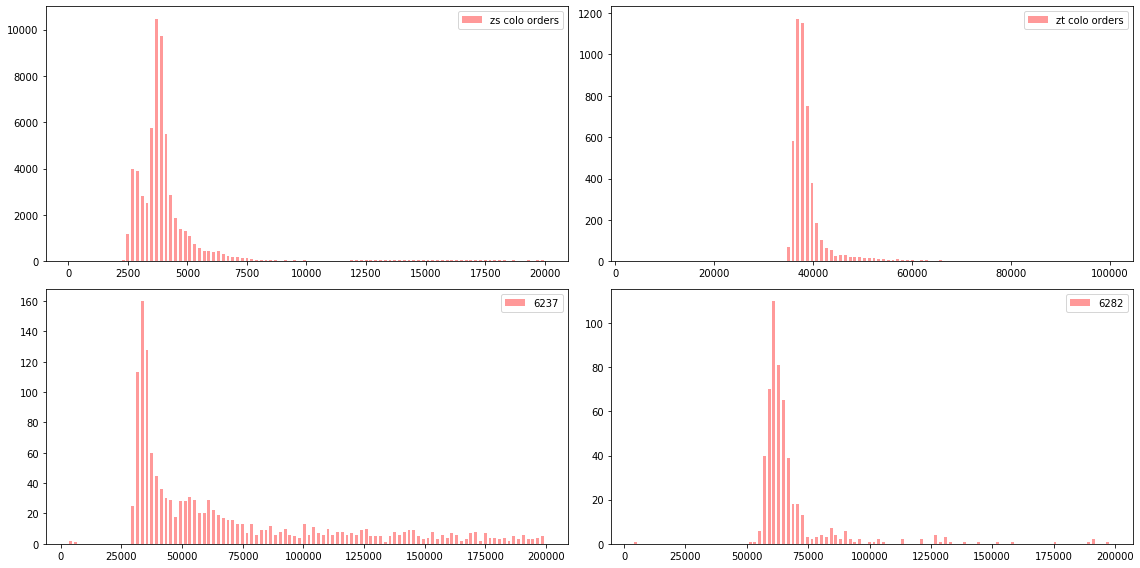

In [104]:
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(221)
ax1.hist(checkLog1['time_diff'].values, bins=100, rwidth=0.6, alpha=0.4, color='red', label='zs colo orders')
ax1.legend()

ax2 = fig.add_subplot(222)
ax2.hist(checkLog2['time_diff'].values, bins=100, rwidth=0.6, alpha=0.4, color='red', label='zt colo orders')
ax2.legend()

ax3 = fig.add_subplot(223)
ax3.hist(checkLog3['time_diff'].values, bins=100, rwidth=0.6, alpha=0.4, color='red', label='6237')
ax3.legend()

ax4 = fig.add_subplot(224)
ax4.hist(checkLog4['time_diff'].values, bins=100, rwidth=0.6, alpha=0.4, color='red', label='6282')
ax4.legend()

fig.tight_layout()
plt.show()

In [32]:
checkLog1['time_diff'].describe([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]).astype('int64')

count     41444
mean      30382
std      112519
min          11
10%        2876
20%        3395
30%        3599
40%        3730
50%        3874
60%        4106
70%        4693
80%       12591
90%       37325
99%      728921
max      999146
Name: time_diff, dtype: int64

In [3]:
checkLog = checkLog.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
checkLog = checkLog[checkLog['ars'].isin([121, 221, 321, 131, 231, 331])]
# checkLog = checkLog[((checkLog['TransactTime'] >= 93300000) & (checkLog['TransactTime'] <= 113000000)) |
#                    ((checkLog['TransactTime'] >= 130300000) & (checkLog['TransactTime'] <= 145500000))]

checkLog['time_diff'] = checkLog['clockAtArrival'] - checkLog['start_time']
checkLog['colo1'] = checkLog['colo'].str[:2]
checkLog['colo_broker'] = checkLog['colo1'] + '_' + checkLog["accCode"].astype(str).str[:2]

from IPython.display import display, HTML
re1 = checkLog.groupby(['date', 'colo', 'accCode'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog.groupby(['date', 'colo', 'accCode'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['date', 'accCode', '10%']], on=['date', 'accCode'])
c1 = checkLog.groupby(['date', 'colo', 'accCode'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['date', 'accCode', '90%']], on=['date', 'accCode'])
re1['accCode'] = re1['accCode'].astype(int)
display(HTML(re1[['date', 'colo', 'accCode', 'count', 'min', '10%', '25%', '50%', '75%', '90%', 'max']].groupby(['colo', 'accCode', 'date']).first().to_html()))

In [6]:
checkLog = checkLog.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
checkLog1 = checkLog[~checkLog['ars'].isin([121, 221, 321, 131, 231, 331, np.nan])]

checkLog1['account'] =  checkLog1['colo'].str[:2] + checkLog1['accCode'].astype(int).astype(str)

checkLog1['time_diff'] = checkLog1['clockAtArrival'] - checkLog1['start_time']
re1 = checkLog1.groupby(['account'])['time_diff'].describe().fillna(0).astype(int).reset_index()
c1 = checkLog1.groupby(['account'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['account', '10%']], on=['account'])
c1 = checkLog1.groupby(['account'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['account', '90%']], on=['account'])
re1 = re1.sort_values(by='account')
re1 = re1[['account', 'count', '10%', '25%', '50%', '75%', '90%']]
re1['sta'] = 'staone'

checkLog2 = checkLog[checkLog['ars'].isin([121, 221, 321, 131, 231, 331])]

checkLog2['account'] =  checkLog2['colo'].str[:2] + checkLog2['accCode'].astype(int).astype(str)

checkLog2['time_diff'] = checkLog2['clockAtArrival'] - checkLog2['start_time']
re2 = checkLog2.groupby(['account'])['time_diff'].describe().fillna(0).astype(int).reset_index()
c1 = checkLog2.groupby(['account'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re2 = pd.merge(re2, c1[['account', '10%']], on=['account'])
c1 = checkLog2.groupby(['account'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re2 = pd.merge(re2, c1[['account', '90%']], on=['account'])
re2 = re2.sort_values(by='account')
re2 = re2[['account', 'count', '10%', '25%', '50%', '75%', '90%']]
re2['sta'] = 'statwo'

re = pd.concat([re1, re2])
display(HTML(re[['sta', 'account', 'count', '10%', '25%', '50%', '75%', '90%']].groupby(['sta', 'account']).first().to_html()))


C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [13]:
checkLog = checkLog.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
checkLog1 = checkLog[~checkLog['ars'].isin([121, 221, 321, 131, 231, 331, np.nan])]
checkLog1['time_diff'] = checkLog1['clockAtArrival'] - checkLog1['start_time']
re1 = checkLog1['time_diff'].describe([0.1, 0.25, 0.5, 0.75, 0.9]).fillna(0).astype(int).reset_index()
re1.index = re1['index'].values
re1 = re1.rename(columns={"time_diff":"staone"})
re1 = re1['staone']
checkLog2 = checkLog[checkLog['ars'].isin([121, 221, 321, 131, 231, 331])]
checkLog2['time_diff'] = checkLog2['clockAtArrival'] - checkLog2['start_time']
re2 = checkLog2['time_diff'].describe([0.1, 0.25, 0.5, 0.75, 0.9]).fillna(0).astype(int).reset_index()
re2.index = re2['index'].values
re2 = re2.rename(columns={"time_diff":"statwo"})
re2 = re2['statwo']
pd.concat([re1, re2], axis=1).loc[["count", "10%", "25%", "50%", "75%", "90%"], :]

C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\win\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,staone,statwo
count,41444,28943
10%,2876,2902
25%,3522,3583
50%,3874,3903
75%,5344,4521
90%,37325,8080


In [4]:
checkLog = checkLog.drop_duplicates(['date', 'secid', 'Price', 'OrderQty', 'Side', 'statusLs', 'TradePriceLs', 'TradeQtyLs', 'ApplSeqNum'], keep=False)
checkLog = checkLog[~checkLog['ars'].isin([121, 221, 321, 131, 231, 331, np.nan])]
# checkLog = checkLog[((checkLog['TransactTime'] >= 93300000) & (checkLog['TransactTime'] <= 113000000)) |
#                    ((checkLog['TransactTime'] >= 130300000) & (checkLog['TransactTime'] <= 145500000))]

checkLog['time_diff'] = checkLog['clockAtArrival'] - checkLog['start_time']
checkLog['colo1'] = checkLog['colo'].str[:2]
checkLog['colo_broker'] = checkLog['colo1'] + '_' + checkLog["accCode"].astype(str).str[:2]

from IPython.display import display, HTML
re1 = checkLog.groupby(['colo', 'accCode'])['time_diff'].describe().fillna(0).astype(int).reset_index()
# re1 = re1[re1['count'] > 20].reset_index()
c1 = checkLog.groupby(['colo', 'accCode'])['time_diff'].apply(lambda x: x.describe([0.1])['10%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"10%"})
re1 = pd.merge(re1, c1[['accCode', '10%']], on=['accCode'])
c1 = checkLog.groupby(['colo', 'accCode'])['time_diff'].apply(lambda x: x.describe([0.9])['90%']).astype(int).reset_index()
c1 = c1.rename(columns={"time_diff":"90%"})
re1 = pd.merge(re1, c1[['accCode', '90%']], on=['accCode'])
re1['accCode'] = re1['accCode'].astype(int)
display(HTML(re1[['colo', 'accCode', 'count',  '10%', '25%', '50%', '75%', '90%']].groupby(['colo', 'accCode']).first().to_html()))

AttributeError: 'Index' object has no attribute 'remove_unused_levels'

In [9]:
startDate = '20200731'
endDate = '20200806'

readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
rawOrderLog = []
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_csv(thisPath)
    data = data.rename(columns={'mdClockAtArrival': 'caamd'})
    rawOrderLog += [data]
rawOrderLog = pd.concat(rawOrderLog, sort=False)
# # rawOrderLog = pd.read_pickle(r'A:\temp\zs66 speed\speedCompare_zs66_0730_0806.pkl')
# # rawOrderLog = rawOrderLog.fillna(0)
# for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
#             'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
#     rawOrderLog[col] = rawOrderLog[col].astype('int64')   
# rawOrderLog = rawOrderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

# rawOrderLog = rawOrderLog[rawOrderLog["secid"] >= 1000000]


# targetStock = rawOrderLog['secid'].unique()
# targetStock = np.array([int(str(i)[1:]) for i in targetStock])
# targetStockSZ = sorted(targetStock[targetStock < 600000])
# targetStockSH = sorted(targetStock[targetStock >= 600000])

# rawOrderLog['clock'] = rawOrderLog['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
# rawOrderLog['broker'] = rawOrderLog['accCode'] // 100
# rawOrderLog["broker"] = np.where(rawOrderLog["accCode"].astype(str).apply(lambda x: len(x) == 6), rawOrderLog['accCode'] // 10000, rawOrderLog["broker"])
# rawOrderLog['colo_broker'] = rawOrderLog['colo'].str[:2] + '_' + rawOrderLog['broker'].astype('str')
# rawOrderLog['order'] = rawOrderLog.groupby(['date', 'accCode', 'secid', 'vai']).grouper.group_info[0]
# rawOrderLog['group'] = rawOrderLog.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
# rawOrderLog['startClock'] = rawOrderLog.groupby(['order'])['clockAtArrival'].transform('first')
# rawOrderLog['duration'] = rawOrderLog['clockAtArrival'] - rawOrderLog['startClock']
# rawOrderLog['orderPrice'] = rawOrderLog['orderPrice'].apply(lambda x: round(x, 2))
# rawOrderLog['tradePrice'] = rawOrderLog['tradePrice'].apply(lambda x: round(x, 2))
# rawOrderLog['orderDirection1'] = np.where(rawOrderLog["orderDirection"] == -2, -1, np.where(
#     rawOrderLog["orderDirection"] == 2, 1, rawOrderLog["orderDirection"]))
# orderLog = rawOrderLog.copy()

# ### make sure updateType == 7 orders < 20 per account, < 100 in total
# if orderLog[orderLog['updateType'] == 7].shape[0] != 0:
#     assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['vai'].count().max() < 20)
#     assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['vai'].count().sum() < 100)

# ### make sure no order has shares > 80w or notional > 800w
# orderLog['orderNtl'] = orderLog['absOrderSize'] * orderLog['orderPrice']
# # assert(orderLog[orderLog['absOrderSize'] > 800000].shape[0] == 0)
# # assert(orderLog[orderLog['orderNtl'] > 8000000].shape[0] == 0)
# if orderLog[orderLog['absOrderSize'] > 800000].shape[0] > 0:
#     print('some order quantity are > 80w')
#     display(orderLog[orderLog['absOrderSize'] > 800000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
#                                                          'orderNtl', 'orderDirection', 'clock', 'order']])
            
# if orderLog[orderLog['orderNtl'] > 8000000].shape[0] > 0:
#     print('some order ntl are > 800w')
#     display(orderLog[orderLog['orderNtl'] > 8000000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
#                                                       'orderNtl', 'orderDirection', 'clock', 'order', "updateType", 
#                                                       "tradePrice", "absOrderSizeCumFilled", "absFilledThisUpdate"]])

# ### make sure same direction in same colo_broker
# orderLog['directNum'] = orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].transform('nunique')
# if len(orderLog[orderLog['directNum'] != 1]) > 0:
#     print('opposite direction for same date, same secid, same vai')
#     display(orderLog[orderLog['directNum'] != 1][['date', 'accCode', 'secid', 'vai', 'orderDirection']])
#     orderLog = orderLog[orderLog['directNum'] == 1]

# assert((orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].nunique() == 1).all() == True)

# ## make sure each account, secid, vai only has one insertion
# a = orderLog[orderLog['updateType'] == 0].groupby(['date', 'accCode', 'secid', 'vai', 'order'])['clockAtArrival'].count()
# if len(a[a > 1]) > 0:
#     print('more than one insertion at same time')
#     a = a[a>1].reset_index()
#     display(a)
#     orderLog = orderLog[~(orderLog['order'].isin(a['order'].unique()))]

# orderLog['isMsg'] = np.where(orderLog['updateType'] == 0, 
#                              np.where(orderLog['mse'] == 100, 1, 0), np.nan)
# orderLog['isMsg'] = orderLog.groupby(['order'])['isMsg'].ffill()

# placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]
# print('%.2f%% SZE orders triggered by msg data'%(placeSZE[placeSZE['isMsg'] == 1].shape[0]/placeSZE.shape[0]*100))

# ### make sure there is no unexpected updateType 
# def getTuple(x):
#     return tuple(i for i in x)

# checkLog = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4))]
# checkLog = checkLog.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
# checkLog['status'] = np.where(checkLog['updateType'].isin([(0, 2, 4), (0, 2, 2, 4), (0, 2, 2, 1, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4), (0, 2, 4, 1, 4), (0, 4), (0, 4, 1, 4), (0, 2, 2, 4, 1, 4), (0, 4, 2, 4)]),0,
#                      np.where(checkLog['updateType'].isin([(0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3), (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 4, 1, 3), (0, 2, 2, 1, 4, 3), (0, 4, 2, 4, 1, 3), (0, 4, 2, 1, 3), (0, 2, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 2, 4, 1, 4, 3)]), 1,
#                      np.where(checkLog['updateType'].isin([(0, 2, 1, 3), (0, 2, 2, 1, 3)]), 2,
#                      np.where(checkLog['updateType'].isin([(0, 3)]), 3,
#                      np.where(checkLog['updateType'].isin([(0,), (0, 2), (0, 2, 1), (0, 2, 2), (0, 2, 4, 1)]), 4, 5)))))
# display(set(checkLog["updateType"].unique()) - set([(0, 2, 4), (0, 2, 2, 4), (0, 2, 2, 1, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4),
#                                                     (0, 2, 4, 1, 4), (0, 4), (0, 4, 1, 4), (0, 2, 2, 4, 1, 4), (0, 4, 2, 4), 
#                                                     (0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3),
#                                                     (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 4, 1, 3), (0, 2, 2, 1, 4, 3),
#                                                     (0, 4, 2, 4, 1, 3), (0, 4, 2, 1, 3), (0, 2, 1, 3), (0, 2, 2, 1, 3),
#                                                     (0, 3), (0,), (0, 2), (0, 2, 1), (0, 2, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 2, 4, 1, 4, 3), 
#                                                     (0, 2, 2), (0, 2, 4, 1)]))

# display(checkLog[checkLog['status'] == 5])
# orderLog = pd.merge(orderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
# orderLog = orderLog[orderLog['status'].isin([0, 1, 2])].reset_index(drop=True)

# ### check status==0 got all traded
# a = orderLog[orderLog['status'] == 0]
# a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
# a.columns = ['order', 'filled', 'total']
# print('in total trade, any fill != total cases')
# display(a[a['filled'] != a['total']])
# if a[a['filled'] != a['total']].shape[0] > 0:
#     removeOrderLs = a[a['filled'] != a['total']]['order'].unique()
#     orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
# ### check status==1 got partial traded
# a = orderLog[orderLog['status'] == 1]
# a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
# a.columns = ['order', 'filled', 'total']
# print('in partial trade, any fill >= total or fill is 0 cases for updateType 4')
# display(a[(a['filled'] >= a['total']) | (a['filled'] == 0)])
# if a[(a['filled'] >= a['total']) | (a['filled'] == 0)].shape[0] > 0:
#     removeOrderLs = a[(a['filled'] >= a['total']) | (a['filled'] == 0)]['order'].unique()
#     orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
# ### check if any cancellation within 1 sec
# a = orderLog[(orderLog['updateType'] == 1) & (orderLog['duration'] < 1e6)]
# print('any cancellation within 1 sec')
# display(a)
# if a.shape[0] > 0:
#     removeOrderLs = a['order'].unique()
#     orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]

# orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

# orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
# orderLog['orderNtl'] = orderLog['orderPrice'] * orderLog['absOrderSize']
# orderLog['tradeNtl'] = np.where(orderLog['updateType'] == 4, orderLog['tradePrice']*orderLog['absFilledThisUpdate'], 0)
# orderLog["ars"] = orderLog.groupby(['order'])['ars'].transform('first')

In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('max_rows', 200)
pd.set_option('max_columns', 200)

perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

startDate = '20200722'
endDate = '20200730'

readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
rawOrderLog = []
for thisDate, thisPath in zip(dateLs, dataPathLs):
    data = pd.read_csv(thisPath)
    data = data.rename(columns={'mdClockAtArrival': 'caamd'})
    rawOrderLog += [data]
rawOrderLog = pd.concat(rawOrderLog, sort=False)
for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
            'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
    rawOrderLog[col] = rawOrderLog[col].astype('int64')   
rawOrderLog = rawOrderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

rawOrderLog = rawOrderLog[rawOrderLog["secid"] >= 1000000]


targetStock = rawOrderLog['secid'].unique()
targetStock = np.array([int(str(i)[1:]) for i in targetStock])
targetStockSZ = sorted(targetStock[targetStock < 600000])
targetStockSH = sorted(targetStock[targetStock >= 600000])

rawOrderLog['clock'] = rawOrderLog['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
rawOrderLog['broker'] = rawOrderLog['accCode'] // 100
rawOrderLog["broker"] = np.where(rawOrderLog["accCode"].astype(str).apply(lambda x: len(x) == 6), rawOrderLog['accCode'] // 10000, rawOrderLog["broker"])
rawOrderLog['colo_broker'] = rawOrderLog['colo'].str[:2] + '_' + rawOrderLog['broker'].astype('str')
rawOrderLog['order'] = rawOrderLog.groupby(['date', 'accCode', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['group'] = rawOrderLog.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['startClock'] = rawOrderLog.groupby(['order'])['clockAtArrival'].transform('first')
rawOrderLog['duration'] = rawOrderLog['clockAtArrival'] - rawOrderLog['startClock']
rawOrderLog['orderPrice'] = rawOrderLog['orderPrice'].apply(lambda x: round(x, 2))
rawOrderLog['tradePrice'] = rawOrderLog['tradePrice'].apply(lambda x: round(x, 2))
rawOrderLog['orderDirection1'] = np.where(rawOrderLog["orderDirection"] == -2, -1, np.where(
    rawOrderLog["orderDirection"] == 2, 1, rawOrderLog["orderDirection"]))
orderLog = rawOrderLog.copy()

### make sure updateType == 7 orders < 20 per account, < 100 in total
if orderLog[orderLog['updateType'] == 7].shape[0] != 0:
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['vai'].count().max() < 20)
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['vai'].count().sum() < 100)

### make sure no order has shares > 80w or notional > 800w
orderLog['orderNtl'] = orderLog['absOrderSize'] * orderLog['orderPrice']
# assert(orderLog[orderLog['absOrderSize'] > 800000].shape[0] == 0)
# assert(orderLog[orderLog['orderNtl'] > 8000000].shape[0] == 0)
if orderLog[orderLog['absOrderSize'] > 800000].shape[0] > 0:
    print('some order quantity are > 80w')
    display(orderLog[orderLog['absOrderSize'] > 800000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                         'orderNtl', 'orderDirection', 'clock', 'order']])
            
if orderLog[orderLog['orderNtl'] > 8000000].shape[0] > 0:
    print('some order ntl are > 800w')
    display(orderLog[orderLog['orderNtl'] > 8000000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                      'orderNtl', 'orderDirection', 'clock', 'order', "updateType", 
                                                      "tradePrice", "absOrderSizeCumFilled", "absFilledThisUpdate"]])

### make sure same direction in same colo_broker
orderLog['directNum'] = orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].transform('nunique')
if len(orderLog[orderLog['directNum'] != 1]) > 0:
    print('opposite direction for same date, same secid, same vai')
    display(orderLog[orderLog['directNum'] != 1][['date', 'accCode', 'secid', 'vai', 'orderDirection']])
    orderLog = orderLog[orderLog['directNum'] == 1]

assert((orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].nunique() == 1).all() == True)

## make sure each account, secid, vai only has one insertion
a = orderLog[orderLog['updateType'] == 0].groupby(['date', 'accCode', 'secid', 'vai', 'order'])['clockAtArrival'].count()
if len(a[a > 1]) > 0:
    print('more than one insertion at same time')
    a = a[a>1].reset_index()
    display(a)
    orderLog = orderLog[~(orderLog['order'].isin(a['order'].unique()))]

orderLog['isMsg'] = np.where(orderLog['updateType'] == 0, 
                             np.where(orderLog['mse'] == 100, 1, 0), np.nan)
orderLog['isMsg'] = orderLog.groupby(['order'])['isMsg'].ffill()

placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]
print('%.2f%% SZE orders triggered by msg data'%(placeSZE[placeSZE['isMsg'] == 1].shape[0]/placeSZE.shape[0]*100))

### make sure there is no unexpected updateType 
def getTuple(x):
    return tuple(i for i in x)

checkLog = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4))]
checkLog = checkLog.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
checkLog['status'] = np.where(checkLog['updateType'].isin([(0, 2, 4), (0, 2, 2, 4), (0, 2, 2, 1, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4), (0, 2, 4, 1, 4), (0, 4), (0, 4, 1, 4), (0, 2, 2, 4, 1, 4), (0, 4, 2, 4)]),0,
                     np.where(checkLog['updateType'].isin([(0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3), (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 4, 1, 3), (0, 2, 2, 1, 4, 3), (0, 4, 2, 4, 1, 3), (0, 4, 2, 1, 3), (0, 2, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 2, 4, 1, 4, 3)]), 1,
                     np.where(checkLog['updateType'].isin([(0, 2, 1, 3), (0, 2, 2, 1, 3)]), 2,
                     np.where(checkLog['updateType'].isin([(0, 3)]), 3,
                     np.where(checkLog['updateType'].isin([(0,), (0, 2), (0, 2, 1), (0, 2, 2), (0, 2, 4, 1)]), 4, 5)))))
display(set(checkLog["updateType"].unique()) - set([(0, 2, 4), (0, 2, 2, 4), (0, 2, 2, 1, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4),
                                                    (0, 2, 4, 1, 4), (0, 4), (0, 4, 1, 4), (0, 2, 2, 4, 1, 4), (0, 4, 2, 4), 
                                                    (0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3),
                                                    (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 4, 1, 3), (0, 2, 2, 1, 4, 3),
                                                    (0, 4, 2, 4, 1, 3), (0, 4, 2, 1, 3), (0, 2, 1, 3), (0, 2, 2, 1, 3),
                                                    (0, 3), (0,), (0, 2), (0, 2, 1), (0, 2, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 2, 4, 1, 4, 3), 
                                                    (0, 2, 2), (0, 2, 4, 1)]))

display(checkLog[checkLog['status'] == 5])
orderLog = pd.merge(orderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
orderLog = orderLog[orderLog['status'].isin([0, 1, 2])].reset_index(drop=True)

### check status==0 got all traded
a = orderLog[orderLog['status'] == 0]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in total trade, any fill != total cases')
display(a[a['filled'] != a['total']])
if a[a['filled'] != a['total']].shape[0] > 0:
    removeOrderLs = a[a['filled'] != a['total']]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### check status==1 got partial traded
a = orderLog[orderLog['status'] == 1]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in partial trade, any fill >= total or fill is 0 cases for updateType 4')
display(a[(a['filled'] >= a['total']) | (a['filled'] == 0)])
if a[(a['filled'] >= a['total']) | (a['filled'] == 0)].shape[0] > 0:
    removeOrderLs = a[(a['filled'] >= a['total']) | (a['filled'] == 0)]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### check if any cancellation within 1 sec
a = orderLog[(orderLog['updateType'] == 1) & (orderLog['duration'] < 1e6)]
print('any cancellation within 1 sec')
display(a)
if a.shape[0] > 0:
    removeOrderLs = a['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]

orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
orderLog['orderNtl'] = orderLog['orderPrice'] * orderLog['absOrderSize']
orderLog['tradeNtl'] = np.where(orderLog['updateType'] == 4, orderLog['tradePrice']*orderLog['absFilledThisUpdate'], 0)
orderLog["ars"] = orderLog.groupby(['order'])['ars'].transform('first')

C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\win\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


some order ntl are > 800w


,date,accCode,secid,vai,absOrderSize,orderPrice,orderNtl,orderDirection,clock,order,updateType,tradePrice,absOrderSizeCumFilled,absFilledThisUpdate
616830,20200729,8971,1600030,21885053,278400,28.76,8006784.0,1,2020-07-29 09:39:20.601912,144438,0,-1.00,0,0
616831,20200729,8971,1600030,21885053,278400,28.76,8006784.0,1,2020-07-29 09:39:20.758504,144438,2,-1.00,0,0
616832,20200729,8971,1600030,21885053,278400,28.76,8006784.0,1,2020-07-29 09:39:20.900148,144438,4,28.74,500,500
616833,20200729,8971,1600030,21885053,278400,28.76,8006784.0,1,2020-07-29 09:39:20.900416,144438,4,28.74,3700,3200
616834,20200729,8971,1600030,21885053,278400,28.76,8006784.0,1,2020-07-29 09:39:20.900585,144438,4,28.74,3700,0
616835,20200729,8971,1600030,21885053,278400,28.76,8006784.0,1,2020-07-29 09:39:20.900793,144438,4,28.74,50000,46300
616836,20200729,8971,1600030,21885053,278400,28.76,8006784.0,1,2020-07-29 09:39:20.903367,144438,4,28.74,50400,400
616837,20200729,8971,1600030,21885053,278400,28.76,8006784.0,1,2020-07-29 09:39:20.903599,144438,4,28.74,57400,7000
616838,20200729,8971,1600030,21885053,278400,28.76,8006784.0,1,2020-07-29 09:39:20.903723,144438,4,28.74,57400,0
616839,20200729,8971,1600030,21885053,278400,28.76,8006784.0,1,2020-07-29 09:39:20.903963,144438,4,28.74,57900,500


opposite direction for same date, same secid, same vai


,date,accCode,secid,vai,orderDirection
228259,20200724,9551,1600055,1275580,1
228260,20200724,9551,1600055,1275580,1
228261,20200724,9551,1600055,1275580,1
228262,20200724,526901,1600055,1275580,-1
228263,20200724,526901,1600055,1275580,-1
228264,20200724,526901,1600055,1275580,-1
360142,20200724,8854,2300132,472600,1
360143,20200724,8854,2300132,472600,1
360144,20200724,8854,2300132,472600,1
360145,20200724,9471,2300132,472600,-1


more than one insertion at same time


,date,accCode,secid,vai,order,clockAtArrival
0,20200722,8865,2300458,57900,7966,2
1,20200722,9208,2300395,55000,9931,2
2,20200722,9451,2300656,2600,11396,2
3,20200722,9758,2002647,3686221,16636,2
4,20200723,9208,2300572,15900,34381,2
5,20200723,9451,2300508,2600,35778,2
6,20200723,9454,2300802,15500,36811,2
7,20200723,9741,1603330,2573912,39564,2
8,20200723,9741,1603330,2574012,39565,3
9,20200723,9741,1603330,2604812,39568,2


98.09% SZE orders triggered by msg data


{(0, 2, 1, 4, 2, 4), (0, 2, 1, 6), (0, 2, 6, 1), (0, 4, 2, 1, 4), (0, 6)}

,order,updateType,status
24375,24379,"(0, 4, 2, 1, 4)",5
32563,32567,"(0, 6)",5
32566,32570,"(0, 6)",5
61542,61559,"(0, 6)",5
61579,61596,"(0, 6)",5
61590,61607,"(0, 6)",5
61594,61611,"(0, 6)",5
61608,61625,"(0, 6)",5
61620,61637,"(0, 6)",5
61621,61638,"(0, 6)",5


in total trade, any fill != total cases


,order,filled,total
16327,20437,500,3700
31303,39140,19600,25100
44828,55395,300,18100
50817,63550,3483,6100
65800,81957,2200,2300
83564,104779,1000,7800
93228,117216,8700,25200
100033,126017,100,500
102204,128843,2700,4900
105194,132348,16600,22000


in partial trade, any fill >= total or fill is 0 cases for updateType 4


,order,filled,total


any cancellation within 1 sec


,Unnamed: 0,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,clock,broker,colo_broker,order,group,startClock,duration,orderDirection1,orderNtl,directNum,isMsg,status


In [11]:
orderLog["server"] = orderLog["colo"].apply(lambda x: x.split("_")[0] + x.split("_")[1] + x.split("_")[2])
orderLog["server_account"] = orderLog["server"] + '_' + orderLog['accCode'].astype('str')
checkLog = orderLog[orderLog['updateType'].isin([0, 3, 4])].reset_index(drop=True)
checkLog = checkLog[checkLog['duration'] <= 1e6]

checkLog["time"] = checkLog["clock"].apply(lambda x: x.strftime("%H%M%S")).astype(int)
ol = checkLog[(checkLog["updateType"] == 0) & (checkLog["ars"] == 11)]["order"].unique()
display(len(ol))
checkLog = checkLog[checkLog["order"].isin(ol)]


checkLog['accountNum'] = checkLog.groupby(['date', 'secid', 'vai', 'isMsg'])['server_account'].transform('nunique')
checkLog = checkLog[checkLog['accountNum'] >= 2]
checkLog['cumFillSize'] = checkLog.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
checkLog['status'] = np.where(checkLog['cumFillSize'] == 0, 2, 
                                np.where(checkLog['cumFillSize'] < checkLog['absOrderSize'], 1, 0))
checkLog = checkLog.groupby(['group', 'order'])[['date', 'server_account', 'secid', 'vai', 'status', 'isMsg']].first().reset_index()

for exchg in ['SZE']:
    
    print(exchg)
    
    if exchg == 'SSE':
        exchangeLog = checkLog[checkLog['secid'] < 2000000]
    else:
        exchangeLog = checkLog[checkLog['secid'] >= 2000000]
    
    result = {}
    for col in ['date', 'isMsg', 'broker1', 'broker2', 'isFast']:
        result[col] = []

    for group, groupData in exchangeLog.groupby(['group']):
        date = groupData['date'].values[0]
        brokerLs = groupData['server_account'].values
        if len(brokerLs) == 0:
            continue
        statusLs = groupData['status'].values
        ixLs = [i for i in range(len(brokerLs))]
        for k, broker1, status1 in zip(ixLs[:-1], brokerLs[:-1], statusLs[:-1]):
            for broker2, status2 in zip(brokerLs[k+1:], statusLs[k+1:]):
                if broker1 != broker2:
                    result['date'] += [date, date]
                    result['isMsg'] += [groupData['isMsg'].values[0], groupData['isMsg'].values[0]]
                    result['broker1'] += [broker1, broker2]
                    result['broker2'] += [broker2, broker1]

                    if status1 < status2:
                        result['isFast'] += [1, 0]
                    elif status1 > status2:
                        result['isFast'] += [0, 1]
                    else:
                        result['isFast'] += [-1, -1]                

    result = pd.DataFrame(result)
    result = result[result['isFast'] != -1]
    result['count'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('count')
    result['fasterSum'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
    result['faster'] = result['fasterSum']/result['count']

    
    summary = pd.DataFrame()
    summaryCols = []
    countCols = []
    fasterCols = []
    for date in result['date'].unique():
        a = result[result['date'] == date].reset_index(drop=True)
        a['count'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('count')
        a['fasterSum'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
        a['faster'] = a['fasterSum']/a['count']
        a = a.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
        a.columns = ['broker1', 'broker2', '%s count'%date, '%s faster'%date]
        summaryCols += ['%s count'%date, '%s faster'%date]
        countCols += ['%s count'%date]
        fasterCols += ['%s faster'%date]
        
        if summary.empty:
            summary = a.copy()
        else:
            summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
    
    a = result.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
    a.columns = ['broker1', 'broker2', 'total count', 'total faster']
    summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
    summaryCols = ['total count', 'total faster'] + summaryCols
    
    
    savePath = r'L:\orderLog\result\relativeSpeed'
    a = summary.groupby(['broker1', 'broker2'])[['total count', 'total faster']].first().reset_index()



    
    countCols += ['total count']
    fasterCols += ['total faster']
    summary['b1'] = summary['broker1'].str[7:11].astype(int) // 100
    summary['b2'] = summary['broker2'].str[7:11].astype(int) // 100
#     summary = summary.groupby(['broker1', 'broker2'])[summaryCols].first()
    for col in countCols:
        summary[col] = summary[col].fillna(0)
        summary[col] = summary[col].astype('int64')
        
    for col in fasterCols:
        summary[col] = summary[col].fillna(-1)
        summary[col] = summary[col].apply(lambda x: '%.0f%%'%(x*100))
        summary[col] = np.where(summary[col] == '-100%', ' ', summary[col])
    
    summary["tt"]=summary[["broker1", "broker2"]].min(axis=1).astype(str) + ' - ' + summary[["broker1", "broker2"]].max(axis=1).astype(str)
    summary = summary.sort_values(by=["tt", "broker1"])
    s1 = summary.groupby("tt").first().reset_index(drop=True)
    display(s1[((s1["broker1"] == 'zs5208_5276') & (s1["b2"] == 62))].sort_values(by='total count', ascending=False))

97538

SZE


,broker1,broker2,20200722 count,20200722 faster,20200723 count,20200723 faster,20200724 count,20200724 faster,20200727 count,20200727 faster,20200728 count,20200728 faster,20200729 count,20200729 faster,20200730 count,20200730 faster,total count,total faster,b1,b2
27,zs5208_5276,zs9608_6282,9,100%,45,100%,54,100%,37,100%,11,100%,8,100%,38,100%,202,100%,52,62
26,zs5208_5276,zs9404_6237,5,100%,8,100%,6,100%,6,100%,11,91%,23,100%,0,,59,98%,52,62


In [90]:
startTm = datetime.datetime.now()


startDate = '20200729'
endDate = '20200729'

readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
dateLs = dateLs[(dateLs >= startDate) & (dateLs <= endDate)]

for date in dateLs:
        
    readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
    orderLog = pd.read_csv(os.path.join(readPath, 'speedCompare_%s.csv'%date))
    
    for col in ['clockAtArrival', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
                'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
        orderLog[col] = orderLog[col].astype('int64')
    
    orderLog = orderLog[orderLog['accCode'].isin([6237, 6282])]
    orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)
    orderLog = orderLog[orderLog["secid"] >= 1000000]
    orderLog['order'] = orderLog.groupby(['date', 'accCode', 'secid', 'vai']).grouper.group_info[0]
    orderLog["ars"] = orderLog.groupby(['order'])['ars'].transform('first')
    orderLog = orderLog[orderLog['ars'] == 11]

    targetStock = orderLog['secid'].unique()
    targetStock = np.array([int(str(i)[1:]) for i in targetStock])
    targetStockSZ = sorted(targetStock[targetStock < 600000])
    targetStockSH = sorted(targetStock[targetStock >= 600000])
        
    readPath = '\\\\192.168.10.30\\Kevin_zhenyu\\KR_daily_data\\' + date + '\\SZ\\'
    mdOrderLogPath = glob.glob(readPath + 'order\\***')
    path1 = []
    for i in mdOrderLogPath:
        if int(os.path.basename(i).split('.')[0]) in targetStockSZ:
            path1.append(i)
    mdTradeLogPath = glob.glob(readPath + 'tick\\***')
    path2 = []
    for i in mdTradeLogPath:
        if int(os.path.basename(i).split('.')[0]) in targetStockSZ:
            path2.append(i)
    
    mdOrderLog = []
    for i in path1:
        df = pd.read_csv(i)
        df["SecurityID"] = int(os.path.basename(i).split('.')[0])
        mdOrderLog += [df]
    mdOrderLog = pd.concat(mdOrderLog).reset_index(drop=True)
    mdOrderLog = mdOrderLog.rename(columns={'OrdType':"OrderType"})
    mdOrderLog['OrderType'] = mdOrderLog['OrderType'].astype(str)
    mdOrderLog = mdOrderLog[mdOrderLog["ChannelNo"] != 4001]
    mdOrderLog = mdOrderLog[['TransactTime', 'SecurityID', 'ApplSeqNum', 'Side',
                             'OrderType', 'Price', 'OrderQty']]
    mdOrderLog['TransactTime'] = (mdOrderLog['TransactTime'] - int(date) * 1000000000).astype(np.int64)
    
    mdTradeLog = []
    for i in path2:
        df = pd.read_csv(i)
        df["SecurityID"] = int(os.path.basename(i).split('.')[0])
        mdTradeLog += [df]
    mdTradeLog = pd.concat(mdTradeLog).reset_index(drop=True)
    mdTradeLog['ExecType'] = mdTradeLog['ExecType'].astype(str)
    mdTradeLog = mdTradeLog.rename(columns={'Qty':"TradeQty", "Price":"TradePrice"})
    mdTradeLog['volumeThisUpdate'] = np.where(mdTradeLog['ExecType'] == 'F', mdTradeLog['TradeQty'], 0)
    mdTradeLog['cum_volume'] = mdTradeLog.groupby(['SecurityID'])['volumeThisUpdate'].cumsum()
    mdTradeLog = mdTradeLog[['TransactTime', 'SecurityID', 'ApplSeqNum', 'cum_volume',
                             'ExecType', 'TradePrice', 'TradeQty', 'BidApplSeqNum', 'OfferApplSeqNum']]
    mdTradeLog['TransactTime'] = (mdTradeLog['TransactTime'] - int(date) * 1000000000).astype(np.int64)

    mdMsgData = pd.concat([mdOrderLog, mdTradeLog], sort=False)
    del mdOrderLog
    del mdTradeLog
    
    mdMsgData = mdMsgData.sort_values(by=['SecurityID', 'ApplSeqNum']).reset_index(drop=True)
    
    saveCols = ['TransactTime', 'SecurityID', 'cum_volume', 'ApplSeqNum', 
                'Side', 'OrderType', 'Price', 'OrderQty', 'ExecType', 'TradePrice', 'TradeQty', 
                'BidApplSeqNum', 'OfferApplSeqNum']
    mdMsgData = mdMsgData[saveCols]
    savePath = r'L:\orderLog\mdData'
    mdMsgData.to_pickle(os.path.join(savePath, 'mdLog62_msg_%s.pkl'%date))
    
print(datetime.datetime.now() - startTm)

0:01:25.533335


In [2]:
startDate = '20200706'
endDate = '20200717'

# readPath = r'\\192.168.10.30\Kevin_zhenyu\orderLog\equityTradeLogs'
# dataPathLs = np.array(glob.glob(os.path.join(readPath, 'speedCompare***.csv')))
# dateLs = np.array([os.path.basename(i).split('_')[1].split('.')[0] for i in dataPathLs])
# dataPathLs = dataPathLs[(dateLs >= startDate) & (dateLs <= endDate)]
# rawOrderLog = []
# for thisDate, thisPath in zip(dateLs, dataPathLs):
#     data = pd.read_csv(thisPath)
#     data = data.rename(columns={'mdClockAtArrival': 'caamd'})
#     rawOrderLog += [data]
# rawOrderLog = pd.concat(rawOrderLog, sort=False)
rawOrderLog = pd.read_pickle(r'A:\temp\zs66 speed\speedCompare_zs62_0722_0730.pkl')
for col in ['clockAtArrival', 'caamd', 'secid', 'updateType', 'vai', 'absFilledThisUpdate', 'orderDirection', 'absOrderSize',
            'absOrderSizeCumFilled', 'date', 'accCode', 'mse']:
    rawOrderLog[col] = rawOrderLog[col].astype('int64')   
rawOrderLog = rawOrderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

rawOrderLog = rawOrderLog[rawOrderLog["secid"] >= 1000000]


targetStock = rawOrderLog['secid'].unique()
targetStock = np.array([int(str(i)[1:]) for i in targetStock])
targetStockSZ = sorted(targetStock[targetStock < 600000])
targetStockSH = sorted(targetStock[targetStock >= 600000])

rawOrderLog['clock'] = rawOrderLog['clockAtArrival'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e6))
rawOrderLog['broker'] = rawOrderLog['accCode'] // 100
rawOrderLog["broker"] = np.where(rawOrderLog["accCode"].astype(str).apply(lambda x: len(x) == 6), rawOrderLog['accCode'] // 10000, rawOrderLog["broker"])
rawOrderLog['colo_broker'] = rawOrderLog['colo'].str[:2] + '_' + rawOrderLog['broker'].astype('str')
rawOrderLog['order'] = rawOrderLog.groupby(['date', 'accCode', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['group'] = rawOrderLog.groupby(['date', 'secid', 'vai']).grouper.group_info[0]
rawOrderLog['startClock'] = rawOrderLog.groupby(['order'])['clockAtArrival'].transform('first')
rawOrderLog['duration'] = rawOrderLog['clockAtArrival'] - rawOrderLog['startClock']
rawOrderLog['orderPrice'] = rawOrderLog['orderPrice'].apply(lambda x: round(x, 2))
rawOrderLog['tradePrice'] = rawOrderLog['tradePrice'].apply(lambda x: round(x, 2))
rawOrderLog['orderDirection1'] = np.where(rawOrderLog["orderDirection"] == -2, -1, np.where(
    rawOrderLog["orderDirection"] == 2, 1, rawOrderLog["orderDirection"]))
orderLog = rawOrderLog.copy()

### make sure updateType == 7 orders < 20 per account, < 100 in total
if orderLog[orderLog['updateType'] == 7].shape[0] != 0:
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['vai'].count().max() < 20)
    assert(orderLog[orderLog['updateType'] == 7].groupby('accCode')['vai'].count().sum() < 100)

### make sure no order has shares > 80w or notional > 800w
orderLog['orderNtl'] = orderLog['absOrderSize'] * orderLog['orderPrice']
# assert(orderLog[orderLog['absOrderSize'] > 800000].shape[0] == 0)
# assert(orderLog[orderLog['orderNtl'] > 8000000].shape[0] == 0)
if orderLog[orderLog['absOrderSize'] > 800000].shape[0] > 0:
    print('some order quantity are > 80w')
    display(orderLog[orderLog['absOrderSize'] > 800000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                         'orderNtl', 'orderDirection', 'clock', 'order']])
            
if orderLog[orderLog['orderNtl'] > 8000000].shape[0] > 0:
    print('some order ntl are > 800w')
    display(orderLog[orderLog['orderNtl'] > 8000000][['date', 'accCode', 'secid', 'vai', 'absOrderSize', 'orderPrice',
                                                      'orderNtl', 'orderDirection', 'clock', 'order', "updateType", 
                                                      "tradePrice", "absOrderSizeCumFilled", "absFilledThisUpdate"]])

### make sure same direction in same colo_broker
orderLog['directNum'] = orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].transform('nunique')
if len(orderLog[orderLog['directNum'] != 1]) > 0:
    print('opposite direction for same date, same secid, same vai')
    display(orderLog[orderLog['directNum'] != 1][['date', 'accCode', 'secid', 'vai', 'orderDirection']])
    orderLog = orderLog[orderLog['directNum'] == 1]

assert((orderLog.groupby(['date', 'secid', 'vai'])['orderDirection1'].nunique() == 1).all() == True)

## make sure each account, secid, vai only has one insertion
a = orderLog[orderLog['updateType'] == 0].groupby(['date', 'accCode', 'secid', 'vai', 'order'])['clockAtArrival'].count()
if len(a[a > 1]) > 0:
    print('more than one insertion at same time')
    a = a[a>1].reset_index()
    display(a)
    orderLog = orderLog[~(orderLog['order'].isin(a['order'].unique()))]

orderLog['isMsg'] = np.where(orderLog['updateType'] == 0, 
                             np.where(orderLog['mse'] == 100, 1, 0), np.nan)
orderLog['isMsg'] = orderLog.groupby(['order'])['isMsg'].ffill()

placeSZE = orderLog[(orderLog['secid'] >= 2000000) & (orderLog['updateType'] == 0)]
print('%.2f%% SZE orders triggered by msg data'%(placeSZE[placeSZE['isMsg'] == 1].shape[0]/placeSZE.shape[0]*100))

### make sure there is no unexpected updateType 
def getTuple(x):
    return tuple(i for i in x)

checkLog = orderLog[~((orderLog['updateType'] == 4) & (orderLog.groupby(['order'])['updateType'].shift(-1) == 4))]
checkLog = checkLog.groupby(['order'])['updateType'].apply(lambda x: getTuple(x)).reset_index()
checkLog['status'] = np.where(checkLog['updateType'].isin([(0, 2, 4), (0, 2, 2, 4), (0, 2, 2, 1, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4), (0, 2, 4, 1, 4), (0, 4), (0, 4, 1, 4), (0, 2, 2, 4, 1, 4), (0, 4, 2, 4)]),0,
                     np.where(checkLog['updateType'].isin([(0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3), (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 4, 1, 3), (0, 2, 2, 1, 4, 3), (0, 4, 2, 4, 1, 3), (0, 4, 2, 1, 3), (0, 2, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 2, 4, 1, 4, 3)]), 1,
                     np.where(checkLog['updateType'].isin([(0, 2, 1, 3), (0, 2, 2, 1, 3)]), 2,
                     np.where(checkLog['updateType'].isin([(0, 3)]), 3,
                     np.where(checkLog['updateType'].isin([(0,), (0, 2), (0, 2, 1), (0, 2, 2), (0, 2, 4, 1)]), 4, 5)))))
display(set(checkLog["updateType"].unique()) - set([(0, 2, 4), (0, 2, 2, 4), (0, 2, 2, 1, 4), (0, 2, 1, 4), (0, 2, 1, 2, 4),
                                                    (0, 2, 4, 1, 4), (0, 4), (0, 4, 1, 4), (0, 2, 2, 4, 1, 4), (0, 4, 2, 4), 
                                                    (0, 2, 4, 1, 3), (0, 2, 4, 1, 4, 3), (0, 2, 1, 4, 3), (0, 4, 1, 3),
                                                    (0, 2, 2, 4, 1, 4, 3), (0, 2, 2, 4, 1, 3), (0, 2, 2, 1, 4, 3),
                                                    (0, 4, 2, 4, 1, 3), (0, 4, 2, 1, 3), (0, 2, 1, 3), (0, 2, 2, 1, 3),
                                                    (0, 3), (0,), (0, 2), (0, 2, 1), (0, 2, 4, 2, 1, 3), (0, 4, 1, 4, 3), (0, 4, 2, 4, 1, 4, 3), 
                                                    (0, 2, 2), (0, 2, 4, 1)]))

display(checkLog[checkLog['status'] == 5])
orderLog = pd.merge(orderLog, checkLog[['order', 'status']], how='left', on=['order'], validate='many_to_one')
orderLog = orderLog[orderLog['status'].isin([0, 1, 2])].reset_index(drop=True)

### check status==0 got all traded
a = orderLog[orderLog['status'] == 0]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in total trade, any fill != total cases')
display(a[a['filled'] != a['total']])
if a[a['filled'] != a['total']].shape[0] > 0:
    removeOrderLs = a[a['filled'] != a['total']]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### check status==1 got partial traded
a = orderLog[orderLog['status'] == 1]
a = a.groupby(['order'])[['absOrderSizeCumFilled', 'absOrderSize']].max().reset_index()
a.columns = ['order', 'filled', 'total']
print('in partial trade, any fill >= total or fill is 0 cases for updateType 4')
display(a[(a['filled'] >= a['total']) | (a['filled'] == 0)])
if a[(a['filled'] >= a['total']) | (a['filled'] == 0)].shape[0] > 0:
    removeOrderLs = a[(a['filled'] >= a['total']) | (a['filled'] == 0)]['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]
    
### check if any cancellation within 1 sec
a = orderLog[(orderLog['updateType'] == 1) & (orderLog['duration'] < 1e6)]
print('any cancellation within 1 sec')
display(a)
if a.shape[0] > 0:
    removeOrderLs = a['order'].unique()
    orderLog = orderLog[~(orderLog['order'].isin(removeOrderLs))]

orderLog = orderLog.sort_values(by=['date', 'secid', 'vai', 'accCode', 'clockAtArrival']).reset_index(drop=True)

orderLog['exchange'] = np.where(orderLog['secid'] >= 2000000, 'SZE', 'SSE')
orderLog['orderNtl'] = orderLog['orderPrice'] * orderLog['absOrderSize']
orderLog['tradeNtl'] = np.where(orderLog['updateType'] == 4, orderLog['tradePrice']*orderLog['absFilledThisUpdate'], 0)
orderLog["ars"] = orderLog.groupby(['order'])['ars'].transform('first')

more than one insertion at same time


,date,accCode,secid,vai,order,clockAtArrival
0,20200724,6282,2002690,2933674,11979,2


98.62% SZE orders triggered by msg data


{(0, 2, 1, 6), (0, 2, 6, 1)}

,order,updateType,status
24194,24195,"(0, 2, 1, 6)",5
24206,24207,"(0, 2, 1, 6)",5
24214,24215,"(0, 2, 1, 6)",5
24224,24225,"(0, 2, 1, 6)",5
24235,24236,"(0, 2, 1, 6)",5
...,...,...,...
29538,29539,"(0, 2, 1, 6)",5
29632,29633,"(0, 2, 1, 6)",5
29639,29640,"(0, 2, 1, 6)",5
29640,29641,"(0, 2, 1, 6)",5


in total trade, any fill != total cases


,order,filled,total


in partial trade, any fill >= total or fill is 0 cases for updateType 4


,order,filled,total


any cancellation within 1 sec


,clockAtArrival,caamd,secid,updateType,vai,ars,absFilledThisUpdate,orderDirection,absOrderSize,absOrderSizeCumFilled,orderPrice,tradePrice,date,accCode,mse,colo,orderSysId,tradeId,sdd,aaa,ApplSeqNum,mrm,mta,mrsb,mrss,mrv,mrb100,mra100,clock,broker,colo_broker,order,group,startClock,duration,orderDirection1,orderNtl,directNum,isMsg,status


In [38]:
orderLog = orderLog[orderLog['accCode'].isin([6237, 6282])]
orderLog["server"] = orderLog["colo"].apply(lambda x: x.split("_")[0] + x.split("_")[1] + x.split("_")[2])
orderLog["server_account"] = orderLog["server"] + '_' + orderLog['accCode'].astype('str')
checkLog = orderLog[orderLog['updateType'].isin([0, 3, 4])].reset_index(drop=True)
checkLog = checkLog[checkLog['duration'] <= 6e6]

checkLog["time"] = checkLog["clock"].apply(lambda x: x.strftime("%H%M%S")).astype(int)
# ol = checkLog[(checkLog["updateType"] == 0) & (checkLog["ars"] == 11)]["order"].unique()
# display(len(ol))
# checkLog = checkLog[checkLog["order"].isin(ol)]


checkLog['accountNum'] = checkLog.groupby(['date', 'secid', 'vai', 'isMsg'])['server_account'].transform('nunique')
checkLog = checkLog[checkLog['accountNum'] >= 2]
checkLog['cumFillSize'] = checkLog.groupby(['order'])['absOrderSizeCumFilled'].transform('max')
checkLog['status'] = np.where(checkLog['cumFillSize'] == 0, 2, 
                                np.where(checkLog['cumFillSize'] < checkLog['absOrderSize'], 1, 0))
checkLog = checkLog.groupby(['group', 'order'])[['date', 'server_account', 'secid', 'vai', 'status', 'isMsg']].first().reset_index()

for exchg in ['SZE']:
    
    print(exchg)
    
    if exchg == 'SSE':
        exchangeLog = checkLog[checkLog['secid'] < 2000000]
    else:
        exchangeLog = checkLog[checkLog['secid'] >= 2000000]
    
    result = {}
    for col in ['date', 'isMsg', 'broker1', 'broker2', 'isFast']:
        result[col] = []

    for group, groupData in exchangeLog.groupby(['group']):
        date = groupData['date'].values[0]
        brokerLs = groupData['server_account'].values
        if len(brokerLs) == 0:
            continue
        statusLs = groupData['status'].values
        ixLs = [i for i in range(len(brokerLs))]
        for k, broker1, status1 in zip(ixLs[:-1], brokerLs[:-1], statusLs[:-1]):
            for broker2, status2 in zip(brokerLs[k+1:], statusLs[k+1:]):
                if broker1 != broker2:
                    result['date'] += [date, date]
                    result['isMsg'] += [groupData['isMsg'].values[0], groupData['isMsg'].values[0]]
                    result['broker1'] += [broker1, broker2]
                    result['broker2'] += [broker2, broker1]

                    if status1 < status2:
                        result['isFast'] += [1, 0]
                    elif status1 > status2:
                        result['isFast'] += [0, 1]
                    else:
                        result['isFast'] += [-1, -1]                

    result = pd.DataFrame(result)
    result = result[result['isFast'] != -1]
    result['count'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('count')
    result['fasterSum'] = result.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
    result['faster'] = result['fasterSum']/result['count']

    
    summary = pd.DataFrame()
    summaryCols = []
    countCols = []
    fasterCols = []
    for date in result['date'].unique():
        a = result[result['date'] == date].reset_index(drop=True)
        a['count'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('count')
        a['fasterSum'] = a.groupby(['broker1', 'broker2'])['isFast'].transform('sum')
        a['faster'] = a['fasterSum']/a['count']
        a = a.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
        a.columns = ['broker1', 'broker2', '%s count'%date, '%s faster'%date]
        summaryCols += ['%s count'%date, '%s faster'%date]
        countCols += ['%s count'%date]
        fasterCols += ['%s faster'%date]
        
        if summary.empty:
            summary = a.copy()
        else:
            summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
    
    a = result.groupby(['broker1', 'broker2'])[['count', 'faster']].mean().reset_index()
    a.columns = ['broker1', 'broker2', 'total count', 'total faster']
    summary = pd.merge(summary, a, how='outer', on=['broker1', 'broker2'], validate='one_to_one')
    summaryCols = ['total count', 'total faster'] + summaryCols
    
    
    savePath = r'L:\orderLog\result\relativeSpeed'
    a = summary.groupby(['broker1', 'broker2'])[['total count', 'total faster']].first().reset_index()



    
    countCols += ['total count']
    fasterCols += ['total faster']
#     summary['b1'] = summary['broker1'].str[7:11].astype(int) // 100
#     summary['b2'] = summary['broker2'].str[7:11].astype(int) // 100
#     summary = summary.groupby(['broker1', 'broker2'])[summaryCols].first()
    for col in countCols:
        summary[col] = summary[col].fillna(0)
        summary[col] = summary[col].astype('int64')
        
    for col in fasterCols:
        summary[col] = summary[col].fillna(-1)
        summary[col] = summary[col].apply(lambda x: '%.0f%%'%(x*100))
        summary[col] = np.where(summary[col] == '-100%', ' ', summary[col])
    
    summary["tt"]=summary[["broker1", "broker2"]].min(axis=1).astype(str) + ' - ' + summary[["broker1", "broker2"]].max(axis=1).astype(str)
    summary = summary.sort_values(by=["tt", "broker1"])
    s1 = summary.groupby("tt").first().reset_index(drop=True)
    display(s1)

SZE


,broker1,broker2,20200722 count,20200722 faster,20200723 count,20200723 faster,20200724 count,20200724 faster,20200727 count,20200727 faster,20200728 count,20200728 faster,20200729 count,20200729 faster,20200730 count,20200730 faster,total count,total faster
0,zs9404_6237,zs9608_6282,23,30%,24,38%,18,44%,4,25%,10,70%,4,75%,5,40%,88,42%


In [39]:
def getTuple(x):
    return tuple(i for i in x)
kk = checkLog.groupby(['date', 'secid', 'vai'])['status'].apply(lambda x: getTuple(x)).reset_index()
kk['exchange'] = np.where(kk['secid'] > 2000000, 'SZ', 'SH')
kk.groupby(['exchange', 'status'])['vai'].size()

exchange  status
SH        (0, 0)     38
          (0, 2)     11
          (1, 0)      2
          (1, 2)      4
          (2, 0)      9
          (2, 1)      4
          (2, 2)    123
SZ        (0, 0)    147
          (0, 1)      7
          (0, 2)     20
          (1, 0)     17
          (1, 2)     10
          (2, 0)     26
          (2, 1)      8
          (2, 2)    286
Name: vai, dtype: int64